# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

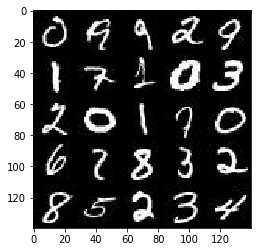

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

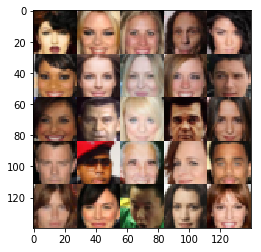

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.01
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        #14x14x64
        
        # adding normalization as recommended
        
        x2 = tf.layers.conv2d(x1, filters=128, kernel_size=5, strides=2, padding='same')
        norm2 = tf.layers.batch_normalization(x2, training=True)  #normalization
        x2 = tf.maximum(alpha * norm2, norm2)
        
        # adding a new layer (two layers to be precise) as recommended 
        
        x3 = tf.layers.conv2d(x2, filters=256, kernel_size=5, strides=1, padding='same')
        norm3 = tf.layers.batch_normalization(x3, training=True)  #normalization
        x3 = tf.maximum(alpha * norm3, norm3)
        
        x4 = tf.layers.conv2d(x3, filters=256, kernel_size=5, strides=1, padding='same')
        norm4 = tf.layers.batch_normalization(x4, training=True)  #normalization
        x4 = tf.maximum(alpha * norm4, norm4)
        
        flat = tf.reshape(x4, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    z_dim = tf.shape(z)
    alpha = 0.2 # 0.01 to 0.2
    
    with tf.variable_scope('generator', reuse= not is_train):
        x1 = tf.layers.dense(z, 7*7*512)  # 128 to 512
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        
        #x1 = tf.batch_normalization(x1, training=is_train)
        
        x1 = tf.maximum(alpha * x1, x1)
        #7x7x128
        
        # adding normalization and more layers (2)
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=3, strides=1, padding='same')
        norm2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #14x14x64
        
        # new layers
        
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=3, strides=1, padding='same')
        norm3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, filters=64, kernel_size=3, strides=2, padding='same')
        norm4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        
        logits = tf.layers.conv2d_transpose(x4, filters=out_channel_dim, kernel_size=3, strides=2, padding='same')
        #28x28xout_channel_dim
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate_scalar, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    import pickle as pkl
    
    # TODO: Build Model
    print_every = 10
    show_every = 100
    steps = 0
    n_images = 4
    inputs_real, inputs_z, learning_rate = model_inputs(data_shape[1], data_shape[2],data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    samples, losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2  # recommended to multiply "batch_images" by 2
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learning_rate: learning_rate_scalar})
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learning_rate: learning_rate_scalar})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, inputs_z, data_shape[3], data_image_mode)
                    
        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1478... Generator Loss: 2.8419
Epoch 1/2... Discriminator Loss: 0.0124... Generator Loss: 11.0178
Epoch 1/2... Discriminator Loss: 1.6087... Generator Loss: 1.1725
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 23.5752
Epoch 1/2... Discriminator Loss: 0.0018... Generator Loss: 18.8324
Epoch 1/2... Discriminator Loss: 0.5261... Generator Loss: 5.8120
Epoch 1/2... Discriminator Loss: 0.2344... Generator Loss: 2.5051
Epoch 1/2... Discriminator Loss: 0.3537... Generator Loss: 2.5024
Epoch 1/2... Discriminator Loss: 0.1351... Generator Loss: 4.9988
Epoch 1/2... Discriminator Loss: 0.6526... Generator Loss: 1.3025


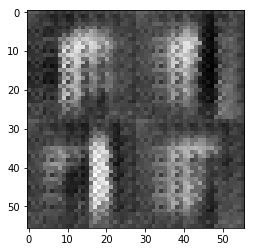

Epoch 1/2... Discriminator Loss: 0.0302... Generator Loss: 5.2424
Epoch 1/2... Discriminator Loss: 16.0722... Generator Loss: 22.7344
Epoch 1/2... Discriminator Loss: 0.3395... Generator Loss: 3.4431
Epoch 1/2... Discriminator Loss: 0.1089... Generator Loss: 3.4743
Epoch 1/2... Discriminator Loss: 0.0481... Generator Loss: 5.4763
Epoch 1/2... Discriminator Loss: 0.4922... Generator Loss: 1.6588
Epoch 1/2... Discriminator Loss: 0.2417... Generator Loss: 2.2787
Epoch 1/2... Discriminator Loss: 0.0747... Generator Loss: 3.6448
Epoch 1/2... Discriminator Loss: 0.2309... Generator Loss: 2.4100
Epoch 1/2... Discriminator Loss: 0.1871... Generator Loss: 2.2812


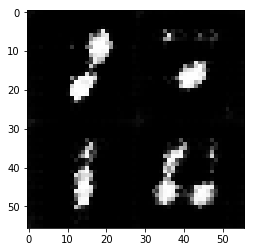

Epoch 1/2... Discriminator Loss: 0.1602... Generator Loss: 3.0692
Epoch 1/2... Discriminator Loss: 0.1067... Generator Loss: 5.8007
Epoch 1/2... Discriminator Loss: 0.0785... Generator Loss: 3.6184
Epoch 1/2... Discriminator Loss: 0.0298... Generator Loss: 5.0949
Epoch 1/2... Discriminator Loss: 0.3820... Generator Loss: 1.8569
Epoch 1/2... Discriminator Loss: 0.3928... Generator Loss: 1.9803
Epoch 1/2... Discriminator Loss: 1.1791... Generator Loss: 0.5893
Epoch 1/2... Discriminator Loss: 0.1658... Generator Loss: 2.8704
Epoch 1/2... Discriminator Loss: 0.0663... Generator Loss: 4.3980
Epoch 1/2... Discriminator Loss: 2.0906... Generator Loss: 0.2772


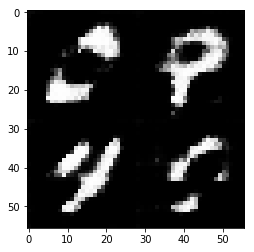

Epoch 1/2... Discriminator Loss: 0.1184... Generator Loss: 4.7206
Epoch 1/2... Discriminator Loss: 0.3159... Generator Loss: 2.5351
Epoch 1/2... Discriminator Loss: 0.0982... Generator Loss: 5.1831
Epoch 1/2... Discriminator Loss: 0.3341... Generator Loss: 1.9488
Epoch 1/2... Discriminator Loss: 2.0057... Generator Loss: 10.5721
Epoch 1/2... Discriminator Loss: 0.1537... Generator Loss: 2.5483
Epoch 1/2... Discriminator Loss: 0.4888... Generator Loss: 1.8563
Epoch 1/2... Discriminator Loss: 0.3744... Generator Loss: 3.6673
Epoch 1/2... Discriminator Loss: 0.7624... Generator Loss: 1.1254
Epoch 1/2... Discriminator Loss: 0.1112... Generator Loss: 3.3796


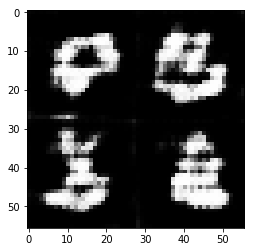

Epoch 1/2... Discriminator Loss: 0.1381... Generator Loss: 3.4636
Epoch 1/2... Discriminator Loss: 0.9515... Generator Loss: 0.8723
Epoch 1/2... Discriminator Loss: 0.3320... Generator Loss: 2.0192
Epoch 1/2... Discriminator Loss: 0.0639... Generator Loss: 5.7436
Epoch 1/2... Discriminator Loss: 1.6571... Generator Loss: 0.4683
Epoch 1/2... Discriminator Loss: 0.1687... Generator Loss: 3.4649
Epoch 1/2... Discriminator Loss: 0.4400... Generator Loss: 1.8911
Epoch 1/2... Discriminator Loss: 0.4239... Generator Loss: 3.4476
Epoch 1/2... Discriminator Loss: 0.2653... Generator Loss: 2.4145
Epoch 1/2... Discriminator Loss: 1.8200... Generator Loss: 0.5551


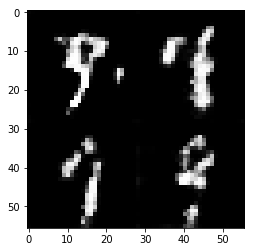

Epoch 1/2... Discriminator Loss: 0.2207... Generator Loss: 3.3402
Epoch 1/2... Discriminator Loss: 0.4182... Generator Loss: 1.6658
Epoch 1/2... Discriminator Loss: 0.6153... Generator Loss: 1.0395
Epoch 1/2... Discriminator Loss: 0.3564... Generator Loss: 2.0449
Epoch 1/2... Discriminator Loss: 0.6970... Generator Loss: 1.0198
Epoch 1/2... Discriminator Loss: 1.2713... Generator Loss: 0.6602
Epoch 1/2... Discriminator Loss: 0.6610... Generator Loss: 1.3119
Epoch 1/2... Discriminator Loss: 0.2847... Generator Loss: 7.4351
Epoch 1/2... Discriminator Loss: 0.3838... Generator Loss: 1.5261
Epoch 1/2... Discriminator Loss: 0.5268... Generator Loss: 4.2491


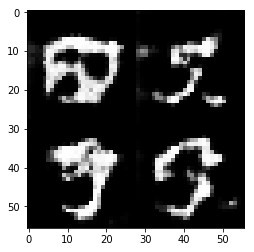

Epoch 1/2... Discriminator Loss: 1.2292... Generator Loss: 0.8249
Epoch 1/2... Discriminator Loss: 0.4330... Generator Loss: 2.1121
Epoch 1/2... Discriminator Loss: 0.0859... Generator Loss: 3.7152
Epoch 1/2... Discriminator Loss: 0.3332... Generator Loss: 2.3939
Epoch 1/2... Discriminator Loss: 0.1243... Generator Loss: 4.2025
Epoch 1/2... Discriminator Loss: 0.3084... Generator Loss: 1.7341
Epoch 1/2... Discriminator Loss: 0.4545... Generator Loss: 1.7957
Epoch 1/2... Discriminator Loss: 0.2816... Generator Loss: 2.4406
Epoch 1/2... Discriminator Loss: 0.8826... Generator Loss: 1.3551
Epoch 1/2... Discriminator Loss: 0.5876... Generator Loss: 1.7029


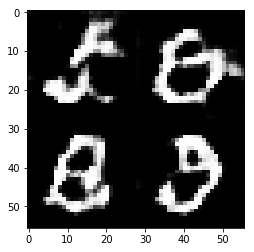

Epoch 1/2... Discriminator Loss: 0.6393... Generator Loss: 1.0159
Epoch 1/2... Discriminator Loss: 0.2961... Generator Loss: 2.5854
Epoch 1/2... Discriminator Loss: 0.3856... Generator Loss: 2.3333
Epoch 1/2... Discriminator Loss: 0.4851... Generator Loss: 1.6839
Epoch 1/2... Discriminator Loss: 0.6608... Generator Loss: 1.0668
Epoch 1/2... Discriminator Loss: 1.7147... Generator Loss: 0.3285
Epoch 1/2... Discriminator Loss: 2.3342... Generator Loss: 0.2250
Epoch 1/2... Discriminator Loss: 1.0342... Generator Loss: 0.9929
Epoch 1/2... Discriminator Loss: 1.9425... Generator Loss: 0.2531
Epoch 1/2... Discriminator Loss: 1.0548... Generator Loss: 0.7753


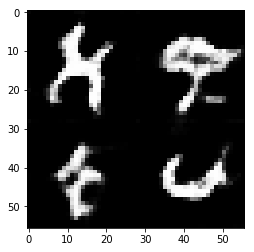

Epoch 1/2... Discriminator Loss: 0.7555... Generator Loss: 0.9165
Epoch 1/2... Discriminator Loss: 2.4475... Generator Loss: 0.1431
Epoch 1/2... Discriminator Loss: 0.5127... Generator Loss: 1.3879
Epoch 1/2... Discriminator Loss: 0.1726... Generator Loss: 3.1403
Epoch 1/2... Discriminator Loss: 0.3809... Generator Loss: 1.5026
Epoch 1/2... Discriminator Loss: 1.0839... Generator Loss: 0.5452
Epoch 1/2... Discriminator Loss: 0.5516... Generator Loss: 2.8420
Epoch 1/2... Discriminator Loss: 1.2416... Generator Loss: 4.0128
Epoch 1/2... Discriminator Loss: 0.2899... Generator Loss: 3.4985
Epoch 1/2... Discriminator Loss: 0.4857... Generator Loss: 2.7140


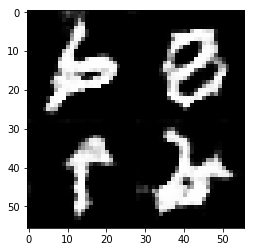

Epoch 1/2... Discriminator Loss: 0.5433... Generator Loss: 1.3379
Epoch 1/2... Discriminator Loss: 1.0168... Generator Loss: 0.6467
Epoch 1/2... Discriminator Loss: 0.2057... Generator Loss: 3.7351
Epoch 1/2... Discriminator Loss: 0.5430... Generator Loss: 1.4107
Epoch 1/2... Discriminator Loss: 1.6161... Generator Loss: 0.3729
Epoch 1/2... Discriminator Loss: 0.7450... Generator Loss: 1.1348
Epoch 1/2... Discriminator Loss: 0.8325... Generator Loss: 0.8403
Epoch 1/2... Discriminator Loss: 0.5280... Generator Loss: 1.1881
Epoch 1/2... Discriminator Loss: 1.0284... Generator Loss: 0.6832
Epoch 1/2... Discriminator Loss: 2.6846... Generator Loss: 0.1135


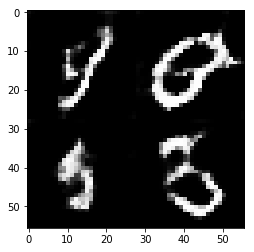

Epoch 1/2... Discriminator Loss: 1.5231... Generator Loss: 0.4017
Epoch 1/2... Discriminator Loss: 1.5128... Generator Loss: 0.3951
Epoch 1/2... Discriminator Loss: 0.5615... Generator Loss: 1.5004
Epoch 1/2... Discriminator Loss: 2.9354... Generator Loss: 0.1500
Epoch 1/2... Discriminator Loss: 0.5685... Generator Loss: 1.1788
Epoch 1/2... Discriminator Loss: 1.0799... Generator Loss: 0.7108
Epoch 1/2... Discriminator Loss: 1.3173... Generator Loss: 0.4952
Epoch 1/2... Discriminator Loss: 0.2933... Generator Loss: 1.8743
Epoch 1/2... Discriminator Loss: 1.3625... Generator Loss: 0.5548
Epoch 1/2... Discriminator Loss: 2.5140... Generator Loss: 0.1412


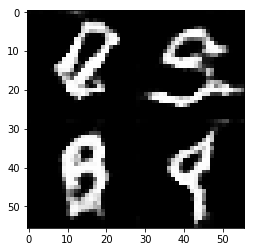

Epoch 1/2... Discriminator Loss: 0.5639... Generator Loss: 1.6309
Epoch 1/2... Discriminator Loss: 1.3528... Generator Loss: 0.6215
Epoch 1/2... Discriminator Loss: 1.5474... Generator Loss: 0.4079
Epoch 1/2... Discriminator Loss: 0.4694... Generator Loss: 1.4906
Epoch 1/2... Discriminator Loss: 0.4425... Generator Loss: 1.2961
Epoch 1/2... Discriminator Loss: 1.7921... Generator Loss: 0.2814
Epoch 1/2... Discriminator Loss: 0.8629... Generator Loss: 0.9158
Epoch 1/2... Discriminator Loss: 0.4268... Generator Loss: 1.4004
Epoch 1/2... Discriminator Loss: 0.7548... Generator Loss: 0.9014
Epoch 1/2... Discriminator Loss: 1.0544... Generator Loss: 0.8162


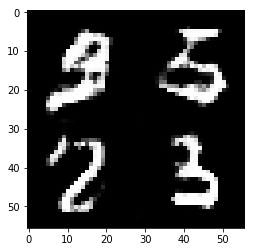

Epoch 1/2... Discriminator Loss: 0.2805... Generator Loss: 1.8153
Epoch 1/2... Discriminator Loss: 0.8869... Generator Loss: 1.0053
Epoch 1/2... Discriminator Loss: 0.9599... Generator Loss: 0.7555
Epoch 1/2... Discriminator Loss: 1.5602... Generator Loss: 0.3661
Epoch 1/2... Discriminator Loss: 0.3271... Generator Loss: 1.8486
Epoch 1/2... Discriminator Loss: 0.9992... Generator Loss: 0.6919
Epoch 1/2... Discriminator Loss: 0.4490... Generator Loss: 1.8367
Epoch 1/2... Discriminator Loss: 0.3556... Generator Loss: 1.4654
Epoch 1/2... Discriminator Loss: 0.7418... Generator Loss: 0.9851
Epoch 1/2... Discriminator Loss: 2.2258... Generator Loss: 0.1903


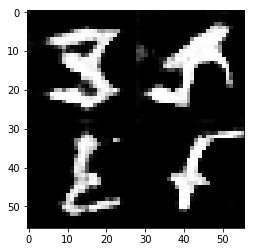

Epoch 1/2... Discriminator Loss: 3.0442... Generator Loss: 0.0902
Epoch 1/2... Discriminator Loss: 1.3276... Generator Loss: 0.5386
Epoch 1/2... Discriminator Loss: 0.1589... Generator Loss: 2.7186
Epoch 1/2... Discriminator Loss: 0.4223... Generator Loss: 1.8379
Epoch 1/2... Discriminator Loss: 0.5242... Generator Loss: 1.3989
Epoch 1/2... Discriminator Loss: 0.1861... Generator Loss: 2.0782
Epoch 1/2... Discriminator Loss: 1.0112... Generator Loss: 0.6167
Epoch 1/2... Discriminator Loss: 0.4571... Generator Loss: 1.4643
Epoch 1/2... Discriminator Loss: 0.1837... Generator Loss: 3.2186
Epoch 1/2... Discriminator Loss: 0.9577... Generator Loss: 0.7382


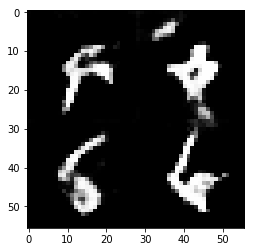

Epoch 1/2... Discriminator Loss: 1.1067... Generator Loss: 0.6021
Epoch 1/2... Discriminator Loss: 0.3909... Generator Loss: 2.0676
Epoch 1/2... Discriminator Loss: 1.6081... Generator Loss: 0.3563
Epoch 1/2... Discriminator Loss: 0.3412... Generator Loss: 1.7200
Epoch 1/2... Discriminator Loss: 2.4277... Generator Loss: 0.1295
Epoch 1/2... Discriminator Loss: 1.0943... Generator Loss: 0.6178
Epoch 1/2... Discriminator Loss: 0.9612... Generator Loss: 0.6083
Epoch 1/2... Discriminator Loss: 0.6299... Generator Loss: 0.9596
Epoch 1/2... Discriminator Loss: 0.3340... Generator Loss: 1.7551
Epoch 1/2... Discriminator Loss: 0.8790... Generator Loss: 0.7890


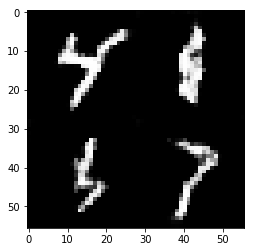

Epoch 1/2... Discriminator Loss: 1.2352... Generator Loss: 0.5257
Epoch 1/2... Discriminator Loss: 2.2357... Generator Loss: 0.2232
Epoch 1/2... Discriminator Loss: 0.4089... Generator Loss: 1.3687
Epoch 1/2... Discriminator Loss: 0.8369... Generator Loss: 0.8415
Epoch 1/2... Discriminator Loss: 0.6477... Generator Loss: 1.7719
Epoch 1/2... Discriminator Loss: 1.5092... Generator Loss: 0.5996
Epoch 1/2... Discriminator Loss: 1.7349... Generator Loss: 0.2703
Epoch 1/2... Discriminator Loss: 1.0485... Generator Loss: 0.7276
Epoch 1/2... Discriminator Loss: 0.2255... Generator Loss: 2.4487
Epoch 1/2... Discriminator Loss: 0.3682... Generator Loss: 2.5523


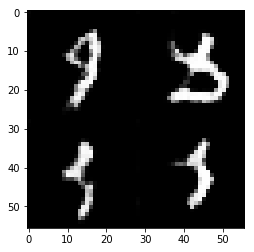

Epoch 1/2... Discriminator Loss: 0.2267... Generator Loss: 5.4984
Epoch 1/2... Discriminator Loss: 1.5321... Generator Loss: 0.3333
Epoch 1/2... Discriminator Loss: 0.6562... Generator Loss: 0.9829
Epoch 1/2... Discriminator Loss: 0.3766... Generator Loss: 1.5885
Epoch 1/2... Discriminator Loss: 1.4613... Generator Loss: 0.3679
Epoch 1/2... Discriminator Loss: 0.3582... Generator Loss: 2.2234
Epoch 1/2... Discriminator Loss: 2.1455... Generator Loss: 0.1987
Epoch 1/2... Discriminator Loss: 3.1786... Generator Loss: 0.0765
Epoch 1/2... Discriminator Loss: 0.9406... Generator Loss: 0.7591
Epoch 1/2... Discriminator Loss: 0.6869... Generator Loss: 1.0109


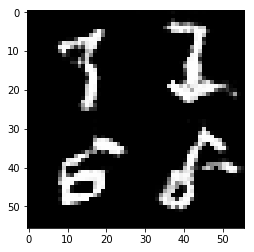

Epoch 1/2... Discriminator Loss: 0.1882... Generator Loss: 4.2201
Epoch 1/2... Discriminator Loss: 0.5711... Generator Loss: 1.8066
Epoch 1/2... Discriminator Loss: 1.1692... Generator Loss: 0.7562
Epoch 1/2... Discriminator Loss: 0.5843... Generator Loss: 1.4458
Epoch 1/2... Discriminator Loss: 1.1290... Generator Loss: 0.5190
Epoch 1/2... Discriminator Loss: 0.7944... Generator Loss: 0.9927
Epoch 1/2... Discriminator Loss: 2.5919... Generator Loss: 0.1412
Epoch 1/2... Discriminator Loss: 3.4032... Generator Loss: 0.0853
Epoch 1/2... Discriminator Loss: 1.5376... Generator Loss: 0.4212
Epoch 1/2... Discriminator Loss: 0.5933... Generator Loss: 2.0224


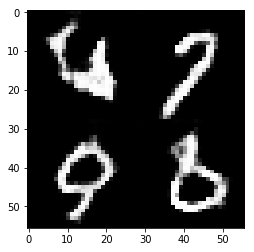

Epoch 1/2... Discriminator Loss: 1.1990... Generator Loss: 0.4868
Epoch 1/2... Discriminator Loss: 2.6392... Generator Loss: 0.1255
Epoch 1/2... Discriminator Loss: 1.0549... Generator Loss: 2.7553
Epoch 1/2... Discriminator Loss: 0.4941... Generator Loss: 1.3302
Epoch 1/2... Discriminator Loss: 1.3065... Generator Loss: 0.6478
Epoch 1/2... Discriminator Loss: 0.4614... Generator Loss: 1.4594
Epoch 1/2... Discriminator Loss: 0.7079... Generator Loss: 1.1117
Epoch 1/2... Discriminator Loss: 2.0558... Generator Loss: 0.1705
Epoch 1/2... Discriminator Loss: 1.0959... Generator Loss: 0.5422
Epoch 1/2... Discriminator Loss: 1.3409... Generator Loss: 0.6009


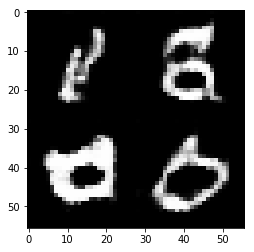

Epoch 1/2... Discriminator Loss: 1.1430... Generator Loss: 0.6141
Epoch 1/2... Discriminator Loss: 0.2229... Generator Loss: 2.0914
Epoch 1/2... Discriminator Loss: 0.3033... Generator Loss: 2.1186
Epoch 1/2... Discriminator Loss: 0.2991... Generator Loss: 1.8071
Epoch 1/2... Discriminator Loss: 0.4627... Generator Loss: 1.3092
Epoch 1/2... Discriminator Loss: 1.6521... Generator Loss: 0.3625
Epoch 1/2... Discriminator Loss: 2.5317... Generator Loss: 0.1992
Epoch 1/2... Discriminator Loss: 0.4342... Generator Loss: 1.3698
Epoch 1/2... Discriminator Loss: 0.1608... Generator Loss: 2.2127
Epoch 1/2... Discriminator Loss: 1.3803... Generator Loss: 0.5622


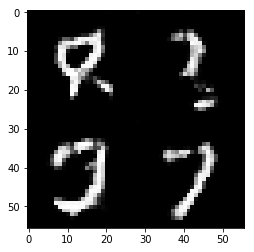

Epoch 1/2... Discriminator Loss: 1.4513... Generator Loss: 0.4797
Epoch 1/2... Discriminator Loss: 1.4723... Generator Loss: 0.4901
Epoch 1/2... Discriminator Loss: 0.3753... Generator Loss: 2.4824
Epoch 1/2... Discriminator Loss: 0.7484... Generator Loss: 2.2272
Epoch 1/2... Discriminator Loss: 1.8393... Generator Loss: 0.2788
Epoch 1/2... Discriminator Loss: 2.0068... Generator Loss: 0.2608
Epoch 1/2... Discriminator Loss: 0.9800... Generator Loss: 0.6483
Epoch 1/2... Discriminator Loss: 0.5555... Generator Loss: 1.0219
Epoch 1/2... Discriminator Loss: 0.6039... Generator Loss: 1.0628
Epoch 1/2... Discriminator Loss: 1.1695... Generator Loss: 0.6499


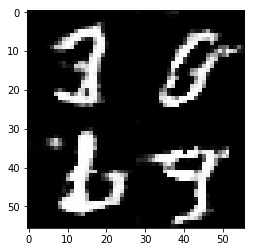

Epoch 1/2... Discriminator Loss: 0.4347... Generator Loss: 2.1835
Epoch 1/2... Discriminator Loss: 0.7960... Generator Loss: 0.8231
Epoch 1/2... Discriminator Loss: 1.9416... Generator Loss: 0.2012
Epoch 1/2... Discriminator Loss: 0.7602... Generator Loss: 1.0504
Epoch 1/2... Discriminator Loss: 1.2567... Generator Loss: 0.4875
Epoch 1/2... Discriminator Loss: 0.5851... Generator Loss: 1.1090
Epoch 1/2... Discriminator Loss: 0.2522... Generator Loss: 2.2011
Epoch 1/2... Discriminator Loss: 0.5577... Generator Loss: 1.6010
Epoch 1/2... Discriminator Loss: 0.8740... Generator Loss: 0.8657
Epoch 1/2... Discriminator Loss: 2.0267... Generator Loss: 5.5876


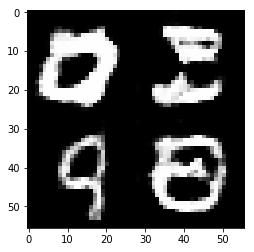

Epoch 1/2... Discriminator Loss: 0.5950... Generator Loss: 1.4066
Epoch 1/2... Discriminator Loss: 0.2684... Generator Loss: 2.1465
Epoch 1/2... Discriminator Loss: 0.3749... Generator Loss: 1.5292
Epoch 1/2... Discriminator Loss: 0.2656... Generator Loss: 2.3367
Epoch 1/2... Discriminator Loss: 0.8548... Generator Loss: 0.7923
Epoch 1/2... Discriminator Loss: 0.6026... Generator Loss: 0.9926
Epoch 1/2... Discriminator Loss: 0.9486... Generator Loss: 0.8623
Epoch 1/2... Discriminator Loss: 0.0799... Generator Loss: 3.2550
Epoch 1/2... Discriminator Loss: 1.1813... Generator Loss: 0.5829
Epoch 1/2... Discriminator Loss: 1.4048... Generator Loss: 0.5884


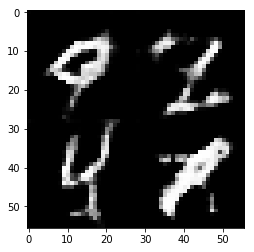

Epoch 1/2... Discriminator Loss: 0.2335... Generator Loss: 2.8306
Epoch 1/2... Discriminator Loss: 0.4129... Generator Loss: 3.4703
Epoch 1/2... Discriminator Loss: 0.8079... Generator Loss: 1.2124
Epoch 1/2... Discriminator Loss: 0.6538... Generator Loss: 1.1247
Epoch 1/2... Discriminator Loss: 2.0522... Generator Loss: 0.2354
Epoch 1/2... Discriminator Loss: 0.9482... Generator Loss: 0.6138
Epoch 1/2... Discriminator Loss: 0.4104... Generator Loss: 1.7994
Epoch 1/2... Discriminator Loss: 0.7048... Generator Loss: 1.2306
Epoch 1/2... Discriminator Loss: 0.4811... Generator Loss: 1.3898
Epoch 1/2... Discriminator Loss: 2.0830... Generator Loss: 0.2588


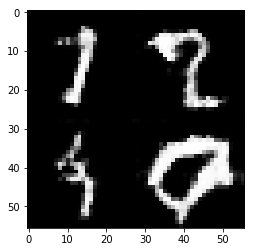

Epoch 1/2... Discriminator Loss: 0.8129... Generator Loss: 1.7577
Epoch 1/2... Discriminator Loss: 0.5500... Generator Loss: 1.3387
Epoch 1/2... Discriminator Loss: 0.2530... Generator Loss: 2.3821
Epoch 1/2... Discriminator Loss: 1.0694... Generator Loss: 0.4894
Epoch 1/2... Discriminator Loss: 0.1544... Generator Loss: 2.5903
Epoch 1/2... Discriminator Loss: 0.0745... Generator Loss: 3.9476
Epoch 1/2... Discriminator Loss: 1.9665... Generator Loss: 0.3293
Epoch 1/2... Discriminator Loss: 0.9692... Generator Loss: 0.8585
Epoch 1/2... Discriminator Loss: 1.8393... Generator Loss: 0.3543
Epoch 1/2... Discriminator Loss: 1.0258... Generator Loss: 0.8970


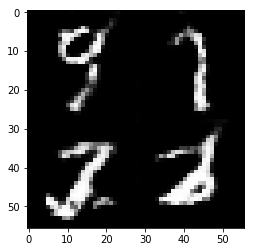

Epoch 1/2... Discriminator Loss: 3.0919... Generator Loss: 0.0666
Epoch 1/2... Discriminator Loss: 1.4781... Generator Loss: 0.7198
Epoch 1/2... Discriminator Loss: 0.5605... Generator Loss: 1.9546
Epoch 1/2... Discriminator Loss: 0.7194... Generator Loss: 0.9567
Epoch 1/2... Discriminator Loss: 0.7287... Generator Loss: 1.0627
Epoch 1/2... Discriminator Loss: 0.6060... Generator Loss: 4.2242
Epoch 1/2... Discriminator Loss: 0.2390... Generator Loss: 2.8106
Epoch 1/2... Discriminator Loss: 2.2505... Generator Loss: 0.3436
Epoch 1/2... Discriminator Loss: 0.3006... Generator Loss: 2.5136
Epoch 1/2... Discriminator Loss: 0.1688... Generator Loss: 3.0308


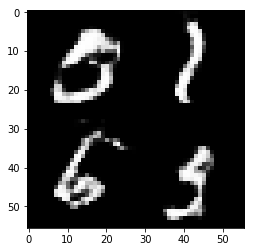

Epoch 1/2... Discriminator Loss: 2.4074... Generator Loss: 0.5059
Epoch 1/2... Discriminator Loss: 0.8004... Generator Loss: 1.0341
Epoch 1/2... Discriminator Loss: 0.7084... Generator Loss: 1.0655
Epoch 1/2... Discriminator Loss: 1.9857... Generator Loss: 0.3099
Epoch 1/2... Discriminator Loss: 0.6420... Generator Loss: 1.2143
Epoch 1/2... Discriminator Loss: 0.2214... Generator Loss: 2.5442
Epoch 1/2... Discriminator Loss: 0.3730... Generator Loss: 1.8092
Epoch 1/2... Discriminator Loss: 0.7258... Generator Loss: 1.3488
Epoch 1/2... Discriminator Loss: 0.4780... Generator Loss: 1.4022
Epoch 1/2... Discriminator Loss: 0.1250... Generator Loss: 2.5763


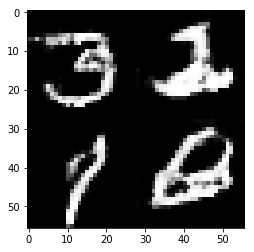

Epoch 1/2... Discriminator Loss: 0.7554... Generator Loss: 6.1628
Epoch 1/2... Discriminator Loss: 3.4780... Generator Loss: 0.0799
Epoch 1/2... Discriminator Loss: 1.8056... Generator Loss: 0.3041
Epoch 1/2... Discriminator Loss: 1.4574... Generator Loss: 0.4195
Epoch 1/2... Discriminator Loss: 0.3888... Generator Loss: 1.5204
Epoch 1/2... Discriminator Loss: 0.7343... Generator Loss: 0.9742
Epoch 1/2... Discriminator Loss: 0.9014... Generator Loss: 0.7762
Epoch 1/2... Discriminator Loss: 0.9450... Generator Loss: 0.8244
Epoch 1/2... Discriminator Loss: 2.0820... Generator Loss: 0.1827
Epoch 1/2... Discriminator Loss: 3.3270... Generator Loss: 0.0739


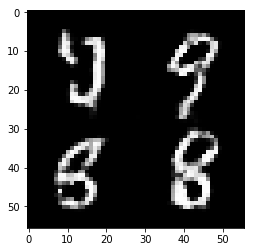

Epoch 1/2... Discriminator Loss: 0.8933... Generator Loss: 2.6528
Epoch 1/2... Discriminator Loss: 1.5657... Generator Loss: 0.5236
Epoch 1/2... Discriminator Loss: 0.5424... Generator Loss: 1.3903
Epoch 1/2... Discriminator Loss: 0.4057... Generator Loss: 1.8984
Epoch 1/2... Discriminator Loss: 0.2627... Generator Loss: 2.1805
Epoch 1/2... Discriminator Loss: 1.4178... Generator Loss: 0.4332
Epoch 1/2... Discriminator Loss: 1.1143... Generator Loss: 0.8251
Epoch 1/2... Discriminator Loss: 1.0194... Generator Loss: 0.6135
Epoch 1/2... Discriminator Loss: 0.6706... Generator Loss: 1.4324
Epoch 1/2... Discriminator Loss: 0.8046... Generator Loss: 5.4078


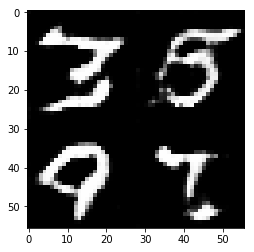

Epoch 1/2... Discriminator Loss: 0.9824... Generator Loss: 0.8950
Epoch 1/2... Discriminator Loss: 0.4394... Generator Loss: 1.9434
Epoch 1/2... Discriminator Loss: 0.5302... Generator Loss: 1.0552
Epoch 1/2... Discriminator Loss: 0.3440... Generator Loss: 1.6092
Epoch 1/2... Discriminator Loss: 2.0756... Generator Loss: 0.2358
Epoch 1/2... Discriminator Loss: 0.4711... Generator Loss: 1.7276
Epoch 1/2... Discriminator Loss: 0.5632... Generator Loss: 1.3168
Epoch 1/2... Discriminator Loss: 0.5863... Generator Loss: 1.8962
Epoch 1/2... Discriminator Loss: 0.2803... Generator Loss: 2.4238
Epoch 1/2... Discriminator Loss: 0.5225... Generator Loss: 1.6622


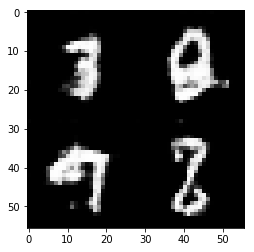

Epoch 1/2... Discriminator Loss: 1.3027... Generator Loss: 0.4355
Epoch 1/2... Discriminator Loss: 0.1769... Generator Loss: 2.7072
Epoch 1/2... Discriminator Loss: 0.2242... Generator Loss: 1.9833
Epoch 1/2... Discriminator Loss: 0.4062... Generator Loss: 1.7160
Epoch 1/2... Discriminator Loss: 1.2456... Generator Loss: 0.4624
Epoch 1/2... Discriminator Loss: 1.1259... Generator Loss: 0.5551
Epoch 1/2... Discriminator Loss: 0.2020... Generator Loss: 2.4810
Epoch 1/2... Discriminator Loss: 0.4808... Generator Loss: 1.4403
Epoch 1/2... Discriminator Loss: 0.3908... Generator Loss: 1.8576
Epoch 1/2... Discriminator Loss: 1.8369... Generator Loss: 0.3465


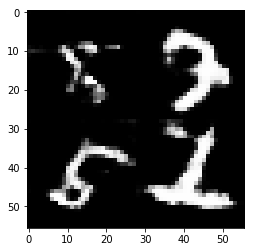

Epoch 1/2... Discriminator Loss: 0.4132... Generator Loss: 1.4117
Epoch 1/2... Discriminator Loss: 0.9278... Generator Loss: 1.0164
Epoch 1/2... Discriminator Loss: 0.6464... Generator Loss: 1.1334
Epoch 1/2... Discriminator Loss: 0.2407... Generator Loss: 2.2146
Epoch 1/2... Discriminator Loss: 2.4297... Generator Loss: 0.1710
Epoch 1/2... Discriminator Loss: 0.4789... Generator Loss: 1.9565
Epoch 1/2... Discriminator Loss: 0.5843... Generator Loss: 4.5146
Epoch 1/2... Discriminator Loss: 0.9956... Generator Loss: 0.6544
Epoch 1/2... Discriminator Loss: 0.3729... Generator Loss: 1.6276
Epoch 1/2... Discriminator Loss: 0.4816... Generator Loss: 1.2794


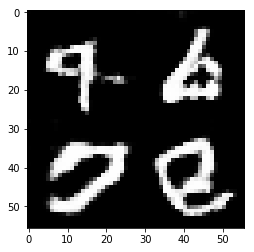

Epoch 1/2... Discriminator Loss: 0.4124... Generator Loss: 1.9485
Epoch 1/2... Discriminator Loss: 1.2764... Generator Loss: 0.5654
Epoch 1/2... Discriminator Loss: 2.4194... Generator Loss: 0.1762
Epoch 1/2... Discriminator Loss: 0.4900... Generator Loss: 1.3444
Epoch 1/2... Discriminator Loss: 1.4398... Generator Loss: 0.4249
Epoch 1/2... Discriminator Loss: 0.8342... Generator Loss: 1.0052
Epoch 1/2... Discriminator Loss: 0.3738... Generator Loss: 7.9774
Epoch 1/2... Discriminator Loss: 0.0769... Generator Loss: 3.4406
Epoch 1/2... Discriminator Loss: 0.0780... Generator Loss: 3.7684
Epoch 1/2... Discriminator Loss: 0.6074... Generator Loss: 1.4446


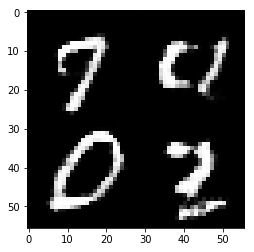

Epoch 1/2... Discriminator Loss: 0.9443... Generator Loss: 1.1956
Epoch 1/2... Discriminator Loss: 0.6205... Generator Loss: 0.9987
Epoch 1/2... Discriminator Loss: 2.2759... Generator Loss: 0.4043
Epoch 1/2... Discriminator Loss: 2.6117... Generator Loss: 0.1734
Epoch 1/2... Discriminator Loss: 3.7395... Generator Loss: 0.0608
Epoch 1/2... Discriminator Loss: 0.3155... Generator Loss: 2.2061
Epoch 1/2... Discriminator Loss: 1.6246... Generator Loss: 0.3756
Epoch 1/2... Discriminator Loss: 0.7069... Generator Loss: 1.1166
Epoch 1/2... Discriminator Loss: 0.7477... Generator Loss: 0.9821
Epoch 1/2... Discriminator Loss: 4.1602... Generator Loss: 0.0333


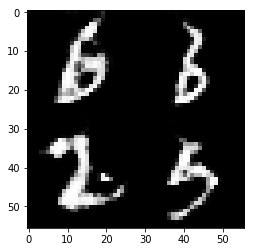

Epoch 1/2... Discriminator Loss: 0.2807... Generator Loss: 2.7861
Epoch 1/2... Discriminator Loss: 1.2002... Generator Loss: 0.4916
Epoch 1/2... Discriminator Loss: 0.0999... Generator Loss: 3.3254
Epoch 1/2... Discriminator Loss: 1.0953... Generator Loss: 0.9948
Epoch 1/2... Discriminator Loss: 2.9437... Generator Loss: 0.1415
Epoch 1/2... Discriminator Loss: 4.0936... Generator Loss: 0.0309
Epoch 1/2... Discriminator Loss: 0.5220... Generator Loss: 1.3413
Epoch 1/2... Discriminator Loss: 3.0117... Generator Loss: 0.0866
Epoch 1/2... Discriminator Loss: 0.4939... Generator Loss: 1.4451
Epoch 1/2... Discriminator Loss: 0.2775... Generator Loss: 2.2845


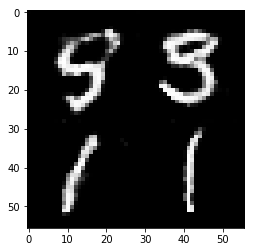

Epoch 1/2... Discriminator Loss: 1.5803... Generator Loss: 0.3157
Epoch 1/2... Discriminator Loss: 0.1589... Generator Loss: 2.4525
Epoch 1/2... Discriminator Loss: 0.2448... Generator Loss: 4.2435
Epoch 1/2... Discriminator Loss: 0.6991... Generator Loss: 1.0853
Epoch 1/2... Discriminator Loss: 0.5086... Generator Loss: 1.2401
Epoch 1/2... Discriminator Loss: 0.6013... Generator Loss: 1.7754
Epoch 1/2... Discriminator Loss: 1.1463... Generator Loss: 0.4976
Epoch 1/2... Discriminator Loss: 1.6435... Generator Loss: 0.3726
Epoch 1/2... Discriminator Loss: 0.4455... Generator Loss: 1.3014
Epoch 1/2... Discriminator Loss: 1.3471... Generator Loss: 0.4464


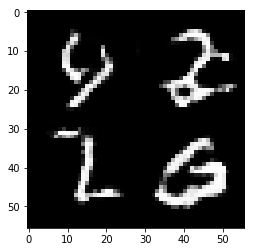

Epoch 1/2... Discriminator Loss: 0.9081... Generator Loss: 1.0130
Epoch 1/2... Discriminator Loss: 0.1898... Generator Loss: 2.8219
Epoch 1/2... Discriminator Loss: 1.3061... Generator Loss: 0.5502
Epoch 1/2... Discriminator Loss: 0.9084... Generator Loss: 0.8623
Epoch 1/2... Discriminator Loss: 0.6948... Generator Loss: 1.1415
Epoch 1/2... Discriminator Loss: 1.0704... Generator Loss: 0.7041
Epoch 1/2... Discriminator Loss: 1.3110... Generator Loss: 0.5008
Epoch 1/2... Discriminator Loss: 0.2244... Generator Loss: 2.2618
Epoch 1/2... Discriminator Loss: 0.6693... Generator Loss: 3.5583
Epoch 1/2... Discriminator Loss: 0.2115... Generator Loss: 3.4050


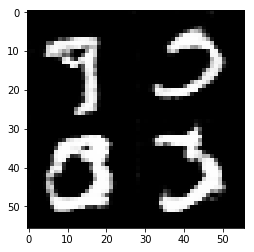

Epoch 1/2... Discriminator Loss: 0.8534... Generator Loss: 0.8790
Epoch 1/2... Discriminator Loss: 0.7919... Generator Loss: 0.8717
Epoch 1/2... Discriminator Loss: 0.5032... Generator Loss: 1.5005
Epoch 1/2... Discriminator Loss: 0.8863... Generator Loss: 0.7635
Epoch 1/2... Discriminator Loss: 1.1827... Generator Loss: 4.4273
Epoch 1/2... Discriminator Loss: 2.0951... Generator Loss: 0.4217
Epoch 1/2... Discriminator Loss: 0.3624... Generator Loss: 2.0803
Epoch 1/2... Discriminator Loss: 0.7982... Generator Loss: 0.9130
Epoch 1/2... Discriminator Loss: 0.7887... Generator Loss: 0.9175
Epoch 1/2... Discriminator Loss: 1.4713... Generator Loss: 0.6988


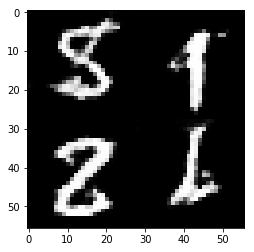

Epoch 1/2... Discriminator Loss: 0.8597... Generator Loss: 0.7113
Epoch 1/2... Discriminator Loss: 0.8492... Generator Loss: 0.6573
Epoch 1/2... Discriminator Loss: 1.1512... Generator Loss: 0.5321
Epoch 1/2... Discriminator Loss: 0.4324... Generator Loss: 1.4009
Epoch 1/2... Discriminator Loss: 1.6553... Generator Loss: 0.5309
Epoch 1/2... Discriminator Loss: 0.7728... Generator Loss: 1.3534
Epoch 1/2... Discriminator Loss: 0.4114... Generator Loss: 2.0790
Epoch 1/2... Discriminator Loss: 1.1418... Generator Loss: 0.7905
Epoch 1/2... Discriminator Loss: 0.2743... Generator Loss: 1.9771
Epoch 1/2... Discriminator Loss: 0.4400... Generator Loss: 1.6362


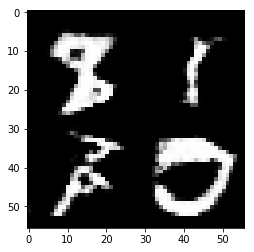

Epoch 1/2... Discriminator Loss: 3.5563... Generator Loss: 0.0464
Epoch 1/2... Discriminator Loss: 1.1087... Generator Loss: 0.5959
Epoch 1/2... Discriminator Loss: 0.7829... Generator Loss: 0.9758
Epoch 1/2... Discriminator Loss: 0.8209... Generator Loss: 0.7807
Epoch 1/2... Discriminator Loss: 0.5582... Generator Loss: 1.0869
Epoch 1/2... Discriminator Loss: 0.7616... Generator Loss: 0.8710
Epoch 1/2... Discriminator Loss: 0.1111... Generator Loss: 3.5490
Epoch 1/2... Discriminator Loss: 0.8906... Generator Loss: 0.8349
Epoch 1/2... Discriminator Loss: 0.0542... Generator Loss: 4.0311
Epoch 1/2... Discriminator Loss: 4.0039... Generator Loss: 0.0297


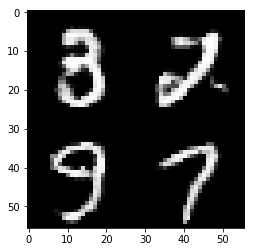

Epoch 1/2... Discriminator Loss: 1.5389... Generator Loss: 0.4400
Epoch 1/2... Discriminator Loss: 0.3997... Generator Loss: 1.3379
Epoch 1/2... Discriminator Loss: 0.8890... Generator Loss: 0.8088
Epoch 1/2... Discriminator Loss: 0.2249... Generator Loss: 1.9765
Epoch 1/2... Discriminator Loss: 2.6915... Generator Loss: 0.1317
Epoch 1/2... Discriminator Loss: 1.1951... Generator Loss: 0.4645
Epoch 1/2... Discriminator Loss: 0.1632... Generator Loss: 5.1147
Epoch 1/2... Discriminator Loss: 0.1277... Generator Loss: 2.9584
Epoch 1/2... Discriminator Loss: 1.4256... Generator Loss: 0.4668
Epoch 1/2... Discriminator Loss: 1.5594... Generator Loss: 0.5175


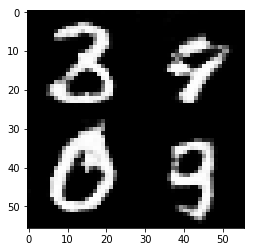

Epoch 1/2... Discriminator Loss: 0.1769... Generator Loss: 2.2084
Epoch 1/2... Discriminator Loss: 0.4586... Generator Loss: 1.4391
Epoch 1/2... Discriminator Loss: 0.4310... Generator Loss: 1.5530
Epoch 1/2... Discriminator Loss: 0.1019... Generator Loss: 2.7971
Epoch 1/2... Discriminator Loss: 0.1696... Generator Loss: 2.8605
Epoch 1/2... Discriminator Loss: 0.1494... Generator Loss: 2.5040
Epoch 1/2... Discriminator Loss: 2.5357... Generator Loss: 0.1717
Epoch 1/2... Discriminator Loss: 0.6761... Generator Loss: 1.0812
Epoch 1/2... Discriminator Loss: 1.2764... Generator Loss: 0.4434
Epoch 1/2... Discriminator Loss: 1.5221... Generator Loss: 0.8638


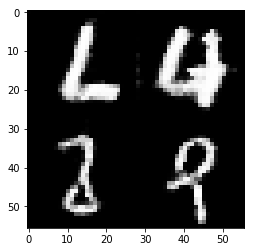

Epoch 1/2... Discriminator Loss: 0.4561... Generator Loss: 1.2177
Epoch 1/2... Discriminator Loss: 1.2044... Generator Loss: 0.4494
Epoch 1/2... Discriminator Loss: 1.2150... Generator Loss: 0.7165
Epoch 1/2... Discriminator Loss: 0.7146... Generator Loss: 0.9415
Epoch 1/2... Discriminator Loss: 2.0376... Generator Loss: 0.1901
Epoch 1/2... Discriminator Loss: 0.8264... Generator Loss: 0.8706
Epoch 1/2... Discriminator Loss: 0.5681... Generator Loss: 1.0432
Epoch 1/2... Discriminator Loss: 0.9890... Generator Loss: 0.8584
Epoch 1/2... Discriminator Loss: 0.6385... Generator Loss: 0.9405
Epoch 1/2... Discriminator Loss: 0.4223... Generator Loss: 1.4770


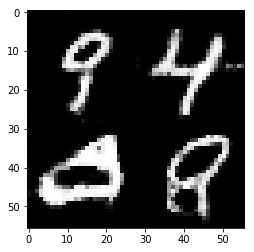

Epoch 1/2... Discriminator Loss: 3.6809... Generator Loss: 0.0335
Epoch 1/2... Discriminator Loss: 1.5734... Generator Loss: 0.4468
Epoch 1/2... Discriminator Loss: 0.4855... Generator Loss: 1.3655
Epoch 1/2... Discriminator Loss: 0.9851... Generator Loss: 0.9466
Epoch 1/2... Discriminator Loss: 1.5271... Generator Loss: 0.4552
Epoch 1/2... Discriminator Loss: 0.1765... Generator Loss: 2.5756
Epoch 1/2... Discriminator Loss: 0.2948... Generator Loss: 2.1257
Epoch 1/2... Discriminator Loss: 0.4884... Generator Loss: 1.1698
Epoch 1/2... Discriminator Loss: 0.8292... Generator Loss: 0.9998
Epoch 1/2... Discriminator Loss: 2.9488... Generator Loss: 4.3883


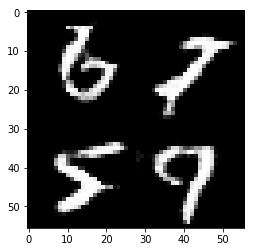

Epoch 1/2... Discriminator Loss: 0.9706... Generator Loss: 0.9863
Epoch 1/2... Discriminator Loss: 0.1089... Generator Loss: 3.6589
Epoch 1/2... Discriminator Loss: 0.3272... Generator Loss: 2.5513
Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 0.7422
Epoch 1/2... Discriminator Loss: 0.2489... Generator Loss: 2.0403
Epoch 1/2... Discriminator Loss: 1.0593... Generator Loss: 0.7596
Epoch 1/2... Discriminator Loss: 1.4912... Generator Loss: 0.4089
Epoch 1/2... Discriminator Loss: 0.0327... Generator Loss: 5.0162
Epoch 1/2... Discriminator Loss: 0.0843... Generator Loss: 3.1361
Epoch 1/2... Discriminator Loss: 1.1475... Generator Loss: 0.6625


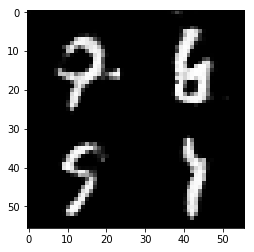

Epoch 1/2... Discriminator Loss: 0.5227... Generator Loss: 1.2761
Epoch 1/2... Discriminator Loss: 0.1008... Generator Loss: 3.3096
Epoch 1/2... Discriminator Loss: 0.4393... Generator Loss: 1.7363
Epoch 1/2... Discriminator Loss: 0.5222... Generator Loss: 1.6253
Epoch 1/2... Discriminator Loss: 0.2560... Generator Loss: 2.4530
Epoch 1/2... Discriminator Loss: 0.4912... Generator Loss: 1.4064
Epoch 1/2... Discriminator Loss: 0.5219... Generator Loss: 1.1188
Epoch 1/2... Discriminator Loss: 0.9606... Generator Loss: 0.8884
Epoch 1/2... Discriminator Loss: 0.1729... Generator Loss: 6.4155
Epoch 1/2... Discriminator Loss: 2.4893... Generator Loss: 0.2201


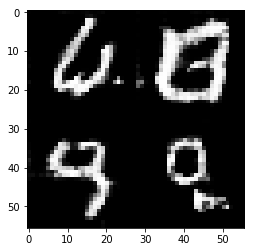

Epoch 1/2... Discriminator Loss: 0.5389... Generator Loss: 1.4745
Epoch 1/2... Discriminator Loss: 0.6045... Generator Loss: 1.0414
Epoch 1/2... Discriminator Loss: 0.6998... Generator Loss: 0.9265
Epoch 1/2... Discriminator Loss: 0.3514... Generator Loss: 2.2391
Epoch 1/2... Discriminator Loss: 1.2739... Generator Loss: 0.4786
Epoch 1/2... Discriminator Loss: 1.1979... Generator Loss: 0.9035
Epoch 1/2... Discriminator Loss: 0.3066... Generator Loss: 1.9079
Epoch 1/2... Discriminator Loss: 2.0374... Generator Loss: 0.2492
Epoch 1/2... Discriminator Loss: 1.8159... Generator Loss: 0.3492
Epoch 1/2... Discriminator Loss: 0.2428... Generator Loss: 2.2336


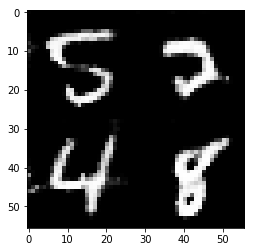

Epoch 1/2... Discriminator Loss: 0.2812... Generator Loss: 2.6675
Epoch 1/2... Discriminator Loss: 0.5711... Generator Loss: 1.8265
Epoch 1/2... Discriminator Loss: 1.4759... Generator Loss: 0.4002
Epoch 1/2... Discriminator Loss: 0.2445... Generator Loss: 2.0309
Epoch 1/2... Discriminator Loss: 1.8273... Generator Loss: 0.5389
Epoch 1/2... Discriminator Loss: 0.3549... Generator Loss: 1.4538
Epoch 1/2... Discriminator Loss: 0.7615... Generator Loss: 1.0127
Epoch 1/2... Discriminator Loss: 0.0659... Generator Loss: 6.7786
Epoch 1/2... Discriminator Loss: 0.5205... Generator Loss: 3.4384
Epoch 1/2... Discriminator Loss: 0.7375... Generator Loss: 1.2794


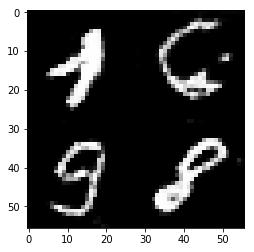

Epoch 1/2... Discriminator Loss: 0.6764... Generator Loss: 1.0053
Epoch 1/2... Discriminator Loss: 0.9733... Generator Loss: 0.7876
Epoch 1/2... Discriminator Loss: 0.3690... Generator Loss: 2.0790
Epoch 1/2... Discriminator Loss: 1.6140... Generator Loss: 0.3027
Epoch 1/2... Discriminator Loss: 0.4784... Generator Loss: 1.6172
Epoch 1/2... Discriminator Loss: 0.1838... Generator Loss: 3.0464
Epoch 1/2... Discriminator Loss: 0.4594... Generator Loss: 1.7832
Epoch 1/2... Discriminator Loss: 0.5482... Generator Loss: 1.2713
Epoch 1/2... Discriminator Loss: 0.2253... Generator Loss: 2.7758
Epoch 1/2... Discriminator Loss: 2.5727... Generator Loss: 0.1004


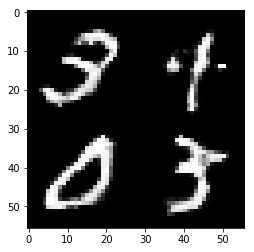

Epoch 1/2... Discriminator Loss: 0.5421... Generator Loss: 1.7928
Epoch 1/2... Discriminator Loss: 3.1121... Generator Loss: 0.0663
Epoch 1/2... Discriminator Loss: 2.8181... Generator Loss: 0.1487
Epoch 1/2... Discriminator Loss: 0.4670... Generator Loss: 1.1495
Epoch 1/2... Discriminator Loss: 1.4151... Generator Loss: 0.4007
Epoch 1/2... Discriminator Loss: 0.8931... Generator Loss: 0.7581
Epoch 1/2... Discriminator Loss: 1.1422... Generator Loss: 0.8928
Epoch 1/2... Discriminator Loss: 0.1831... Generator Loss: 3.1647
Epoch 1/2... Discriminator Loss: 1.5196... Generator Loss: 0.4488
Epoch 1/2... Discriminator Loss: 0.5563... Generator Loss: 1.4629


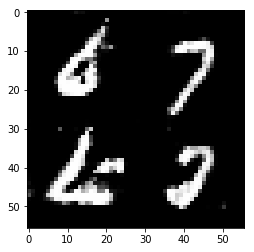

Epoch 1/2... Discriminator Loss: 2.1203... Generator Loss: 0.2406
Epoch 1/2... Discriminator Loss: 0.7861... Generator Loss: 0.8470
Epoch 1/2... Discriminator Loss: 0.8932... Generator Loss: 0.9040
Epoch 1/2... Discriminator Loss: 1.3739... Generator Loss: 0.5859
Epoch 1/2... Discriminator Loss: 0.0621... Generator Loss: 4.1814
Epoch 1/2... Discriminator Loss: 0.1144... Generator Loss: 2.6672
Epoch 1/2... Discriminator Loss: 0.1352... Generator Loss: 3.7470
Epoch 1/2... Discriminator Loss: 0.3445... Generator Loss: 1.8142
Epoch 1/2... Discriminator Loss: 0.0445... Generator Loss: 3.4841
Epoch 1/2... Discriminator Loss: 1.0749... Generator Loss: 0.6627


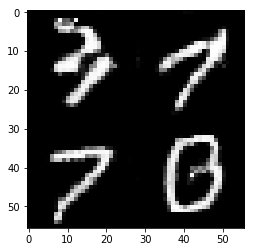

Epoch 1/2... Discriminator Loss: 0.6424... Generator Loss: 0.9771
Epoch 1/2... Discriminator Loss: 0.0843... Generator Loss: 3.0605
Epoch 1/2... Discriminator Loss: 0.6440... Generator Loss: 1.3447
Epoch 1/2... Discriminator Loss: 0.1594... Generator Loss: 8.7199
Epoch 1/2... Discriminator Loss: 4.1716... Generator Loss: 0.0263
Epoch 1/2... Discriminator Loss: 1.6370... Generator Loss: 0.4222
Epoch 1/2... Discriminator Loss: 0.5241... Generator Loss: 2.2877
Epoch 1/2... Discriminator Loss: 0.6847... Generator Loss: 1.0195
Epoch 1/2... Discriminator Loss: 0.8773... Generator Loss: 0.6881
Epoch 1/2... Discriminator Loss: 0.3539... Generator Loss: 1.3965


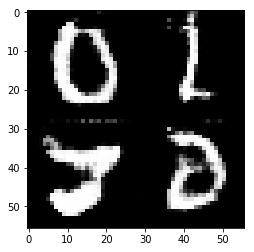

Epoch 1/2... Discriminator Loss: 0.2625... Generator Loss: 2.1584
Epoch 1/2... Discriminator Loss: 1.6560... Generator Loss: 0.3604
Epoch 1/2... Discriminator Loss: 1.4326... Generator Loss: 0.3351
Epoch 1/2... Discriminator Loss: 0.2522... Generator Loss: 2.3873
Epoch 1/2... Discriminator Loss: 0.5325... Generator Loss: 1.0490
Epoch 1/2... Discriminator Loss: 0.6832... Generator Loss: 0.9173
Epoch 1/2... Discriminator Loss: 0.4039... Generator Loss: 1.6918
Epoch 1/2... Discriminator Loss: 0.8939... Generator Loss: 0.8629
Epoch 1/2... Discriminator Loss: 0.3783... Generator Loss: 1.4167
Epoch 1/2... Discriminator Loss: 0.8425... Generator Loss: 0.8805


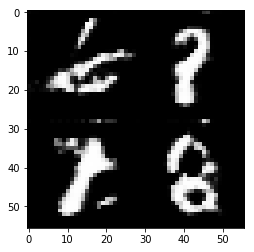

Epoch 1/2... Discriminator Loss: 1.2071... Generator Loss: 5.8619
Epoch 1/2... Discriminator Loss: 3.2015... Generator Loss: 0.0739
Epoch 1/2... Discriminator Loss: 1.9750... Generator Loss: 0.3310
Epoch 1/2... Discriminator Loss: 0.0667... Generator Loss: 3.9741
Epoch 1/2... Discriminator Loss: 0.6056... Generator Loss: 3.9379
Epoch 1/2... Discriminator Loss: 1.1773... Generator Loss: 0.8403
Epoch 1/2... Discriminator Loss: 0.1055... Generator Loss: 2.7533
Epoch 1/2... Discriminator Loss: 0.4321... Generator Loss: 1.2619
Epoch 1/2... Discriminator Loss: 0.6519... Generator Loss: 1.3518
Epoch 1/2... Discriminator Loss: 0.2505... Generator Loss: 2.3278


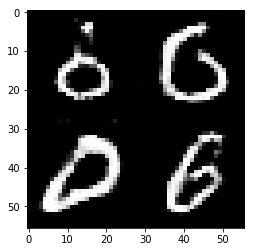

Epoch 1/2... Discriminator Loss: 0.9703... Generator Loss: 2.1023
Epoch 1/2... Discriminator Loss: 0.1682... Generator Loss: 3.7887
Epoch 1/2... Discriminator Loss: 0.6120... Generator Loss: 1.3960
Epoch 1/2... Discriminator Loss: 0.9967... Generator Loss: 0.7729
Epoch 1/2... Discriminator Loss: 0.8595... Generator Loss: 1.2407
Epoch 1/2... Discriminator Loss: 1.7645... Generator Loss: 0.4215
Epoch 1/2... Discriminator Loss: 0.2444... Generator Loss: 2.9922
Epoch 1/2... Discriminator Loss: 0.6412... Generator Loss: 1.1379
Epoch 1/2... Discriminator Loss: 0.0503... Generator Loss: 3.3060
Epoch 1/2... Discriminator Loss: 0.1445... Generator Loss: 2.2664


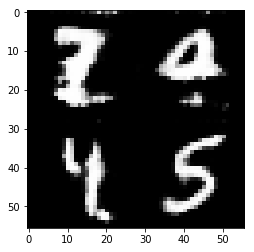

Epoch 1/2... Discriminator Loss: 0.9860... Generator Loss: 0.5822
Epoch 1/2... Discriminator Loss: 0.8384... Generator Loss: 0.6481
Epoch 1/2... Discriminator Loss: 0.4838... Generator Loss: 1.6076
Epoch 1/2... Discriminator Loss: 0.1689... Generator Loss: 4.0620
Epoch 1/2... Discriminator Loss: 0.1194... Generator Loss: 2.7716
Epoch 1/2... Discriminator Loss: 0.1603... Generator Loss: 2.3587
Epoch 1/2... Discriminator Loss: 0.0566... Generator Loss: 4.7946
Epoch 1/2... Discriminator Loss: 0.2407... Generator Loss: 2.0966
Epoch 1/2... Discriminator Loss: 1.1056... Generator Loss: 0.6437
Epoch 1/2... Discriminator Loss: 1.1094... Generator Loss: 0.7426


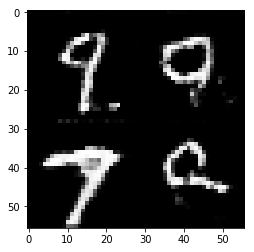

Epoch 1/2... Discriminator Loss: 0.1431... Generator Loss: 2.5191
Epoch 1/2... Discriminator Loss: 2.2455... Generator Loss: 0.2538
Epoch 1/2... Discriminator Loss: 0.3757... Generator Loss: 1.7861
Epoch 1/2... Discriminator Loss: 0.8215... Generator Loss: 0.9825
Epoch 1/2... Discriminator Loss: 2.5353... Generator Loss: 0.1268
Epoch 1/2... Discriminator Loss: 1.9807... Generator Loss: 0.4955
Epoch 1/2... Discriminator Loss: 0.1923... Generator Loss: 3.5280
Epoch 1/2... Discriminator Loss: 0.9972... Generator Loss: 0.6114
Epoch 1/2... Discriminator Loss: 0.1801... Generator Loss: 2.3280
Epoch 1/2... Discriminator Loss: 0.6834... Generator Loss: 1.1515


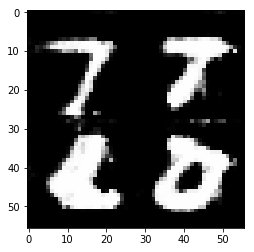

Epoch 1/2... Discriminator Loss: 0.1935... Generator Loss: 5.2065
Epoch 1/2... Discriminator Loss: 0.5264... Generator Loss: 1.7348
Epoch 1/2... Discriminator Loss: 1.1158... Generator Loss: 0.5258
Epoch 1/2... Discriminator Loss: 3.7486... Generator Loss: 0.0312
Epoch 1/2... Discriminator Loss: 0.7374... Generator Loss: 1.1216
Epoch 1/2... Discriminator Loss: 0.3148... Generator Loss: 1.7132
Epoch 1/2... Discriminator Loss: 0.7322... Generator Loss: 1.3029
Epoch 1/2... Discriminator Loss: 0.4138... Generator Loss: 1.4571
Epoch 1/2... Discriminator Loss: 1.6677... Generator Loss: 0.3530
Epoch 1/2... Discriminator Loss: 0.2100... Generator Loss: 2.1596


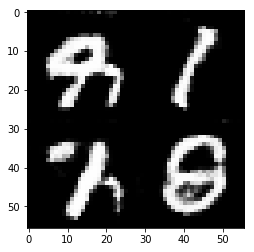

Epoch 1/2... Discriminator Loss: 0.2923... Generator Loss: 1.9525
Epoch 1/2... Discriminator Loss: 0.4710... Generator Loss: 1.5014
Epoch 1/2... Discriminator Loss: 0.9454... Generator Loss: 0.6868
Epoch 1/2... Discriminator Loss: 0.0449... Generator Loss: 3.9371
Epoch 1/2... Discriminator Loss: 0.4897... Generator Loss: 1.2566
Epoch 1/2... Discriminator Loss: 0.4430... Generator Loss: 1.5898
Epoch 1/2... Discriminator Loss: 1.3749... Generator Loss: 0.5028
Epoch 1/2... Discriminator Loss: 0.3026... Generator Loss: 2.0943
Epoch 1/2... Discriminator Loss: 0.8355... Generator Loss: 0.8835
Epoch 1/2... Discriminator Loss: 0.2325... Generator Loss: 2.0157


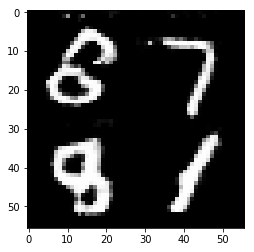

Epoch 1/2... Discriminator Loss: 0.3263... Generator Loss: 1.7335
Epoch 1/2... Discriminator Loss: 0.5412... Generator Loss: 1.2175
Epoch 1/2... Discriminator Loss: 0.7342... Generator Loss: 0.9801
Epoch 1/2... Discriminator Loss: 0.2736... Generator Loss: 1.8137
Epoch 1/2... Discriminator Loss: 0.1785... Generator Loss: 2.1570
Epoch 1/2... Discriminator Loss: 0.3812... Generator Loss: 2.7456
Epoch 1/2... Discriminator Loss: 1.2877... Generator Loss: 0.4825
Epoch 1/2... Discriminator Loss: 1.3930... Generator Loss: 0.4217
Epoch 1/2... Discriminator Loss: 0.6226... Generator Loss: 0.9745
Epoch 1/2... Discriminator Loss: 0.2774... Generator Loss: 3.9997


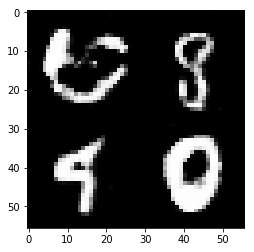

Epoch 2/2... Discriminator Loss: 0.1288... Generator Loss: 2.6248
Epoch 2/2... Discriminator Loss: 1.0068... Generator Loss: 0.6448
Epoch 2/2... Discriminator Loss: 0.1737... Generator Loss: 2.1526
Epoch 2/2... Discriminator Loss: 0.4047... Generator Loss: 1.8968
Epoch 2/2... Discriminator Loss: 0.6838... Generator Loss: 0.8289
Epoch 2/2... Discriminator Loss: 0.0403... Generator Loss: 4.9665
Epoch 2/2... Discriminator Loss: 0.6689... Generator Loss: 0.9789
Epoch 2/2... Discriminator Loss: 0.2240... Generator Loss: 2.0841
Epoch 2/2... Discriminator Loss: 0.0615... Generator Loss: 3.2041
Epoch 2/2... Discriminator Loss: 0.4749... Generator Loss: 1.5615


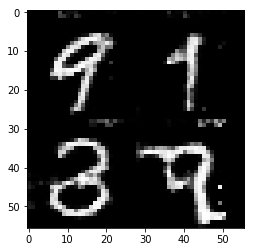

Epoch 2/2... Discriminator Loss: 0.4446... Generator Loss: 1.2465
Epoch 2/2... Discriminator Loss: 0.1641... Generator Loss: 2.4276
Epoch 2/2... Discriminator Loss: 0.4826... Generator Loss: 1.2829
Epoch 2/2... Discriminator Loss: 0.0478... Generator Loss: 4.6873
Epoch 2/2... Discriminator Loss: 0.0866... Generator Loss: 4.1254
Epoch 2/2... Discriminator Loss: 0.3376... Generator Loss: 1.9216
Epoch 2/2... Discriminator Loss: 0.4702... Generator Loss: 1.5700
Epoch 2/2... Discriminator Loss: 0.3073... Generator Loss: 2.3195
Epoch 2/2... Discriminator Loss: 0.4425... Generator Loss: 1.7191
Epoch 2/2... Discriminator Loss: 0.7144... Generator Loss: 1.0168


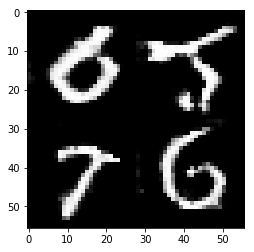

Epoch 2/2... Discriminator Loss: 0.3196... Generator Loss: 1.7189
Epoch 2/2... Discriminator Loss: 0.2335... Generator Loss: 2.1574
Epoch 2/2... Discriminator Loss: 0.2629... Generator Loss: 2.0726
Epoch 2/2... Discriminator Loss: 0.6828... Generator Loss: 1.0364
Epoch 2/2... Discriminator Loss: 0.1354... Generator Loss: 2.8130
Epoch 2/2... Discriminator Loss: 0.4420... Generator Loss: 1.7902
Epoch 2/2... Discriminator Loss: 0.3504... Generator Loss: 1.9459
Epoch 2/2... Discriminator Loss: 0.0744... Generator Loss: 3.6665
Epoch 2/2... Discriminator Loss: 0.4679... Generator Loss: 1.2563
Epoch 2/2... Discriminator Loss: 0.3806... Generator Loss: 1.8408


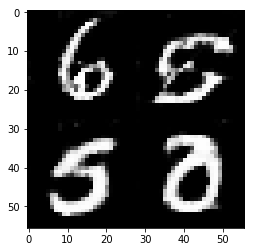

Epoch 2/2... Discriminator Loss: 1.5497... Generator Loss: 0.3842
Epoch 2/2... Discriminator Loss: 1.5953... Generator Loss: 0.3357
Epoch 2/2... Discriminator Loss: 0.0929... Generator Loss: 3.4122
Epoch 2/2... Discriminator Loss: 0.8495... Generator Loss: 0.7827
Epoch 2/2... Discriminator Loss: 1.8526... Generator Loss: 0.2682
Epoch 2/2... Discriminator Loss: 0.7020... Generator Loss: 1.0493
Epoch 2/2... Discriminator Loss: 0.7689... Generator Loss: 0.7831
Epoch 2/2... Discriminator Loss: 0.1068... Generator Loss: 4.3121
Epoch 2/2... Discriminator Loss: 0.2315... Generator Loss: 2.2915
Epoch 2/2... Discriminator Loss: 0.2649... Generator Loss: 1.7403


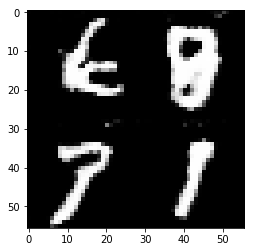

Epoch 2/2... Discriminator Loss: 0.6026... Generator Loss: 1.0558
Epoch 2/2... Discriminator Loss: 0.4841... Generator Loss: 1.1446
Epoch 2/2... Discriminator Loss: 0.4600... Generator Loss: 1.4775
Epoch 2/2... Discriminator Loss: 0.3531... Generator Loss: 1.5072
Epoch 2/2... Discriminator Loss: 3.5200... Generator Loss: 10.4226
Epoch 2/2... Discriminator Loss: 0.2667... Generator Loss: 2.0433
Epoch 2/2... Discriminator Loss: 1.1957... Generator Loss: 1.0522
Epoch 2/2... Discriminator Loss: 3.4288... Generator Loss: 0.0542
Epoch 2/2... Discriminator Loss: 1.0975... Generator Loss: 0.6743
Epoch 2/2... Discriminator Loss: 0.4405... Generator Loss: 1.7220


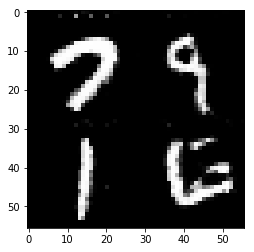

Epoch 2/2... Discriminator Loss: 1.7253... Generator Loss: 0.3766
Epoch 2/2... Discriminator Loss: 0.7049... Generator Loss: 0.8689
Epoch 2/2... Discriminator Loss: 0.9977... Generator Loss: 0.7678
Epoch 2/2... Discriminator Loss: 0.1602... Generator Loss: 2.5965
Epoch 2/2... Discriminator Loss: 3.1350... Generator Loss: 0.1621
Epoch 2/2... Discriminator Loss: 0.7322... Generator Loss: 1.2945
Epoch 2/2... Discriminator Loss: 0.0110... Generator Loss: 5.7901
Epoch 2/2... Discriminator Loss: 0.7141... Generator Loss: 1.4164
Epoch 2/2... Discriminator Loss: 0.4816... Generator Loss: 4.7264
Epoch 2/2... Discriminator Loss: 3.7180... Generator Loss: 0.0554


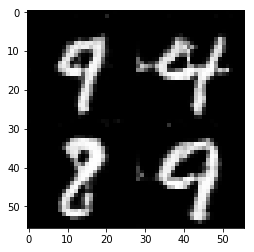

Epoch 2/2... Discriminator Loss: 0.1247... Generator Loss: 3.4952
Epoch 2/2... Discriminator Loss: 0.5386... Generator Loss: 1.2526
Epoch 2/2... Discriminator Loss: 0.8320... Generator Loss: 0.9456
Epoch 2/2... Discriminator Loss: 1.0481... Generator Loss: 0.5809
Epoch 2/2... Discriminator Loss: 1.0201... Generator Loss: 0.7264
Epoch 2/2... Discriminator Loss: 1.5423... Generator Loss: 0.6192
Epoch 2/2... Discriminator Loss: 2.3861... Generator Loss: 0.2633
Epoch 2/2... Discriminator Loss: 0.2841... Generator Loss: 2.0243
Epoch 2/2... Discriminator Loss: 0.1723... Generator Loss: 2.3593
Epoch 2/2... Discriminator Loss: 0.7090... Generator Loss: 1.0401


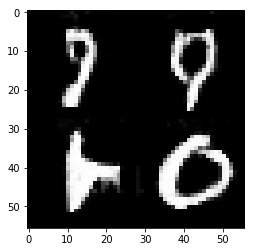

Epoch 2/2... Discriminator Loss: 0.5582... Generator Loss: 1.1653
Epoch 2/2... Discriminator Loss: 0.1324... Generator Loss: 2.9177
Epoch 2/2... Discriminator Loss: 0.1783... Generator Loss: 2.5809
Epoch 2/2... Discriminator Loss: 1.2354... Generator Loss: 1.0957
Epoch 2/2... Discriminator Loss: 1.0397... Generator Loss: 0.6794
Epoch 2/2... Discriminator Loss: 0.3668... Generator Loss: 1.6510
Epoch 2/2... Discriminator Loss: 0.5967... Generator Loss: 1.1236
Epoch 2/2... Discriminator Loss: 0.4167... Generator Loss: 1.3472
Epoch 2/2... Discriminator Loss: 3.1734... Generator Loss: 0.1100
Epoch 2/2... Discriminator Loss: 0.4233... Generator Loss: 4.0476


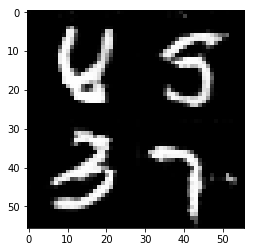

Epoch 2/2... Discriminator Loss: 0.0559... Generator Loss: 3.7025
Epoch 2/2... Discriminator Loss: 0.1485... Generator Loss: 3.4810
Epoch 2/2... Discriminator Loss: 1.3230... Generator Loss: 1.1768
Epoch 2/2... Discriminator Loss: 0.3511... Generator Loss: 2.0905
Epoch 2/2... Discriminator Loss: 0.9415... Generator Loss: 1.0120
Epoch 2/2... Discriminator Loss: 0.1377... Generator Loss: 6.9337
Epoch 2/2... Discriminator Loss: 1.9120... Generator Loss: 0.3836
Epoch 2/2... Discriminator Loss: 0.0521... Generator Loss: 4.6128
Epoch 2/2... Discriminator Loss: 1.2811... Generator Loss: 0.8468
Epoch 2/2... Discriminator Loss: 0.3735... Generator Loss: 1.3511


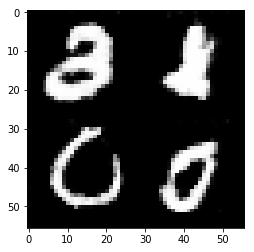

Epoch 2/2... Discriminator Loss: 0.1853... Generator Loss: 2.2329
Epoch 2/2... Discriminator Loss: 0.9395... Generator Loss: 0.6842
Epoch 2/2... Discriminator Loss: 0.1218... Generator Loss: 3.1641
Epoch 2/2... Discriminator Loss: 1.8345... Generator Loss: 0.2777
Epoch 2/2... Discriminator Loss: 0.9423... Generator Loss: 0.6922
Epoch 2/2... Discriminator Loss: 0.2390... Generator Loss: 6.5120
Epoch 2/2... Discriminator Loss: 0.4836... Generator Loss: 1.9275
Epoch 2/2... Discriminator Loss: 2.2442... Generator Loss: 0.2299
Epoch 2/2... Discriminator Loss: 0.1666... Generator Loss: 2.7953
Epoch 2/2... Discriminator Loss: 0.2497... Generator Loss: 2.0635


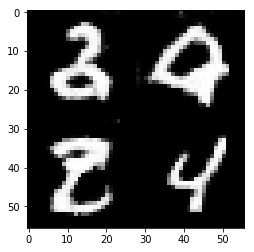

Epoch 2/2... Discriminator Loss: 0.0103... Generator Loss: 7.2856
Epoch 2/2... Discriminator Loss: 0.2063... Generator Loss: 2.3272
Epoch 2/2... Discriminator Loss: 0.4033... Generator Loss: 1.4757
Epoch 2/2... Discriminator Loss: 0.6321... Generator Loss: 1.1290
Epoch 2/2... Discriminator Loss: 0.6734... Generator Loss: 0.9825
Epoch 2/2... Discriminator Loss: 0.4647... Generator Loss: 1.4454
Epoch 2/2... Discriminator Loss: 0.2103... Generator Loss: 2.8814
Epoch 2/2... Discriminator Loss: 0.3456... Generator Loss: 1.7841
Epoch 2/2... Discriminator Loss: 0.1483... Generator Loss: 2.2399
Epoch 2/2... Discriminator Loss: 0.1818... Generator Loss: 2.6487


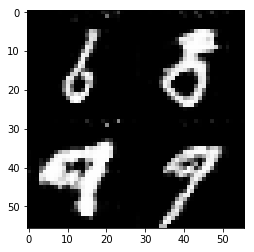

Epoch 2/2... Discriminator Loss: 1.4612... Generator Loss: 0.5325
Epoch 2/2... Discriminator Loss: 0.3916... Generator Loss: 1.7223
Epoch 2/2... Discriminator Loss: 0.4275... Generator Loss: 1.2835
Epoch 2/2... Discriminator Loss: 0.3062... Generator Loss: 1.8508
Epoch 2/2... Discriminator Loss: 1.0230... Generator Loss: 0.7301
Epoch 2/2... Discriminator Loss: 0.0708... Generator Loss: 3.1749
Epoch 2/2... Discriminator Loss: 1.0868... Generator Loss: 1.0191
Epoch 2/2... Discriminator Loss: 0.1582... Generator Loss: 2.4608
Epoch 2/2... Discriminator Loss: 0.0601... Generator Loss: 3.9838
Epoch 2/2... Discriminator Loss: 0.1927... Generator Loss: 2.3429


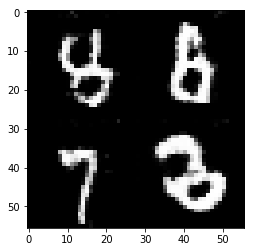

Epoch 2/2... Discriminator Loss: 0.5318... Generator Loss: 1.3668
Epoch 2/2... Discriminator Loss: 0.3275... Generator Loss: 2.0327
Epoch 2/2... Discriminator Loss: 1.4402... Generator Loss: 0.3530
Epoch 2/2... Discriminator Loss: 0.0273... Generator Loss: 4.4775
Epoch 2/2... Discriminator Loss: 1.6535... Generator Loss: 0.4167
Epoch 2/2... Discriminator Loss: 0.4155... Generator Loss: 1.6019
Epoch 2/2... Discriminator Loss: 0.1631... Generator Loss: 2.4632
Epoch 2/2... Discriminator Loss: 0.8133... Generator Loss: 0.9959
Epoch 2/2... Discriminator Loss: 0.0208... Generator Loss: 5.5064
Epoch 2/2... Discriminator Loss: 2.8902... Generator Loss: 0.0995


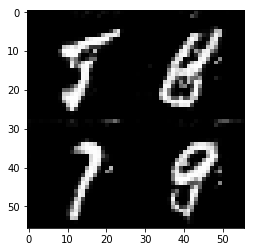

Epoch 2/2... Discriminator Loss: 0.7211... Generator Loss: 0.9523
Epoch 2/2... Discriminator Loss: 0.1137... Generator Loss: 3.2803
Epoch 2/2... Discriminator Loss: 0.1482... Generator Loss: 2.5412
Epoch 2/2... Discriminator Loss: 1.8626... Generator Loss: 0.2899
Epoch 2/2... Discriminator Loss: 0.9008... Generator Loss: 0.9588
Epoch 2/2... Discriminator Loss: 0.0418... Generator Loss: 3.4888
Epoch 2/2... Discriminator Loss: 1.6012... Generator Loss: 0.4289
Epoch 2/2... Discriminator Loss: 0.3159... Generator Loss: 2.0103
Epoch 2/2... Discriminator Loss: 0.9131... Generator Loss: 0.8795
Epoch 2/2... Discriminator Loss: 1.1388... Generator Loss: 4.4754


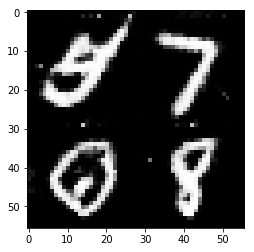

Epoch 2/2... Discriminator Loss: 0.8346... Generator Loss: 0.8973
Epoch 2/2... Discriminator Loss: 2.8278... Generator Loss: 0.1199
Epoch 2/2... Discriminator Loss: 0.1222... Generator Loss: 3.5061
Epoch 2/2... Discriminator Loss: 0.5468... Generator Loss: 1.2216
Epoch 2/2... Discriminator Loss: 0.2737... Generator Loss: 2.4226
Epoch 2/2... Discriminator Loss: 0.1175... Generator Loss: 2.7089
Epoch 2/2... Discriminator Loss: 2.0207... Generator Loss: 0.2622
Epoch 2/2... Discriminator Loss: 0.4423... Generator Loss: 1.4162
Epoch 2/2... Discriminator Loss: 0.1706... Generator Loss: 2.8099
Epoch 2/2... Discriminator Loss: 0.2750... Generator Loss: 1.9184


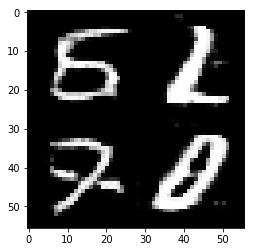

Epoch 2/2... Discriminator Loss: 0.7999... Generator Loss: 0.9518
Epoch 2/2... Discriminator Loss: 0.1942... Generator Loss: 2.1902
Epoch 2/2... Discriminator Loss: 0.8086... Generator Loss: 0.7162
Epoch 2/2... Discriminator Loss: 0.1538... Generator Loss: 2.4454
Epoch 2/2... Discriminator Loss: 0.0523... Generator Loss: 3.6116
Epoch 2/2... Discriminator Loss: 0.1472... Generator Loss: 2.5745
Epoch 2/2... Discriminator Loss: 0.4194... Generator Loss: 1.4137
Epoch 2/2... Discriminator Loss: 0.0830... Generator Loss: 3.3255
Epoch 2/2... Discriminator Loss: 0.3445... Generator Loss: 1.5806
Epoch 2/2... Discriminator Loss: 0.5974... Generator Loss: 1.2355


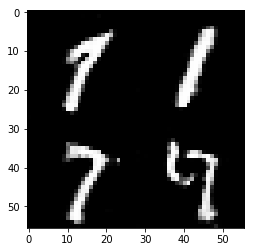

Epoch 2/2... Discriminator Loss: 0.3847... Generator Loss: 1.5251
Epoch 2/2... Discriminator Loss: 0.0383... Generator Loss: 4.4843
Epoch 2/2... Discriminator Loss: 0.1273... Generator Loss: 3.6459
Epoch 2/2... Discriminator Loss: 1.3871... Generator Loss: 0.5772
Epoch 2/2... Discriminator Loss: 2.2604... Generator Loss: 0.3731
Epoch 2/2... Discriminator Loss: 0.2539... Generator Loss: 2.3203
Epoch 2/2... Discriminator Loss: 0.3607... Generator Loss: 4.8705
Epoch 2/2... Discriminator Loss: 1.5492... Generator Loss: 0.4408
Epoch 2/2... Discriminator Loss: 1.1120... Generator Loss: 0.7375
Epoch 2/2... Discriminator Loss: 1.4961... Generator Loss: 0.6387


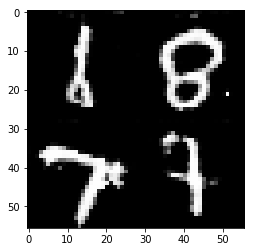

Epoch 2/2... Discriminator Loss: 0.4164... Generator Loss: 2.0729
Epoch 2/2... Discriminator Loss: 0.4058... Generator Loss: 1.6066
Epoch 2/2... Discriminator Loss: 1.6740... Generator Loss: 0.5208
Epoch 2/2... Discriminator Loss: 0.2744... Generator Loss: 2.0797
Epoch 2/2... Discriminator Loss: 0.7597... Generator Loss: 0.8949
Epoch 2/2... Discriminator Loss: 0.3342... Generator Loss: 1.4177
Epoch 2/2... Discriminator Loss: 0.8320... Generator Loss: 0.9910
Epoch 2/2... Discriminator Loss: 0.0901... Generator Loss: 3.3399
Epoch 2/2... Discriminator Loss: 0.1620... Generator Loss: 2.5170
Epoch 2/2... Discriminator Loss: 0.4218... Generator Loss: 1.4923


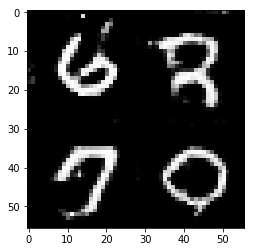

Epoch 2/2... Discriminator Loss: 1.4187... Generator Loss: 0.4869
Epoch 2/2... Discriminator Loss: 0.6416... Generator Loss: 1.0569
Epoch 2/2... Discriminator Loss: 1.3029... Generator Loss: 0.4763
Epoch 2/2... Discriminator Loss: 0.3536... Generator Loss: 2.1573
Epoch 2/2... Discriminator Loss: 0.8997... Generator Loss: 1.0735
Epoch 2/2... Discriminator Loss: 0.0444... Generator Loss: 4.1049
Epoch 2/2... Discriminator Loss: 0.1533... Generator Loss: 2.6693
Epoch 2/2... Discriminator Loss: 1.8621... Generator Loss: 0.4441
Epoch 2/2... Discriminator Loss: 0.4477... Generator Loss: 1.2398
Epoch 2/2... Discriminator Loss: 0.0217... Generator Loss: 4.7185


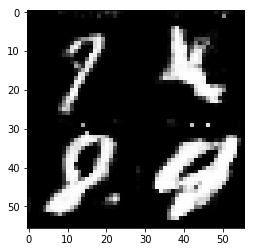

Epoch 2/2... Discriminator Loss: 1.2384... Generator Loss: 0.5978
Epoch 2/2... Discriminator Loss: 1.1982... Generator Loss: 0.6028
Epoch 2/2... Discriminator Loss: 2.0847... Generator Loss: 0.3048
Epoch 2/2... Discriminator Loss: 0.3534... Generator Loss: 1.5087
Epoch 2/2... Discriminator Loss: 0.1180... Generator Loss: 3.3239
Epoch 2/2... Discriminator Loss: 0.7533... Generator Loss: 0.9307
Epoch 2/2... Discriminator Loss: 0.5709... Generator Loss: 1.2270
Epoch 2/2... Discriminator Loss: 0.8998... Generator Loss: 1.1137
Epoch 2/2... Discriminator Loss: 0.2263... Generator Loss: 2.1901
Epoch 2/2... Discriminator Loss: 1.4285... Generator Loss: 0.5612


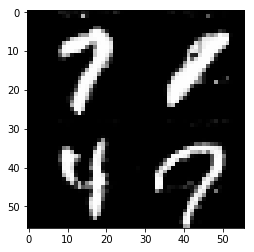

Epoch 2/2... Discriminator Loss: 0.1100... Generator Loss: 2.9835
Epoch 2/2... Discriminator Loss: 0.2109... Generator Loss: 2.2885
Epoch 2/2... Discriminator Loss: 1.0630... Generator Loss: 0.5072
Epoch 2/2... Discriminator Loss: 0.0389... Generator Loss: 3.7743
Epoch 2/2... Discriminator Loss: 0.0561... Generator Loss: 3.5135
Epoch 2/2... Discriminator Loss: 1.9568... Generator Loss: 0.4052
Epoch 2/2... Discriminator Loss: 1.1450... Generator Loss: 0.5131
Epoch 2/2... Discriminator Loss: 0.0237... Generator Loss: 4.5575
Epoch 2/2... Discriminator Loss: 1.2293... Generator Loss: 0.5230
Epoch 2/2... Discriminator Loss: 0.7108... Generator Loss: 1.0486


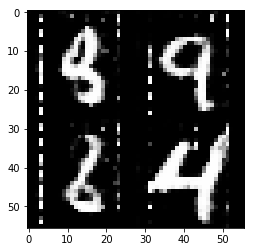

Epoch 2/2... Discriminator Loss: 0.0717... Generator Loss: 4.7937
Epoch 2/2... Discriminator Loss: 0.3125... Generator Loss: 1.8988
Epoch 2/2... Discriminator Loss: 0.3795... Generator Loss: 4.5055
Epoch 2/2... Discriminator Loss: 1.2985... Generator Loss: 0.5396
Epoch 2/2... Discriminator Loss: 2.2272... Generator Loss: 10.2596
Epoch 2/2... Discriminator Loss: 1.6932... Generator Loss: 0.3849
Epoch 2/2... Discriminator Loss: 0.2591... Generator Loss: 2.9309
Epoch 2/2... Discriminator Loss: 0.5145... Generator Loss: 9.1501
Epoch 2/2... Discriminator Loss: 0.1659... Generator Loss: 3.1223
Epoch 2/2... Discriminator Loss: 0.1701... Generator Loss: 2.2637


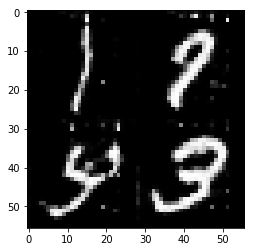

Epoch 2/2... Discriminator Loss: 0.3061... Generator Loss: 2.4874
Epoch 2/2... Discriminator Loss: 0.4202... Generator Loss: 1.3439
Epoch 2/2... Discriminator Loss: 0.1487... Generator Loss: 2.6620
Epoch 2/2... Discriminator Loss: 0.0550... Generator Loss: 3.9320
Epoch 2/2... Discriminator Loss: 0.9178... Generator Loss: 0.9636
Epoch 2/2... Discriminator Loss: 0.2589... Generator Loss: 2.3575
Epoch 2/2... Discriminator Loss: 1.9683... Generator Loss: 0.2247
Epoch 2/2... Discriminator Loss: 0.3237... Generator Loss: 1.6229
Epoch 2/2... Discriminator Loss: 0.2498... Generator Loss: 1.8890
Epoch 2/2... Discriminator Loss: 1.3799... Generator Loss: 0.6244


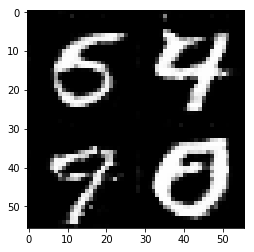

Epoch 2/2... Discriminator Loss: 0.2444... Generator Loss: 2.2510
Epoch 2/2... Discriminator Loss: 3.3188... Generator Loss: 0.1124
Epoch 2/2... Discriminator Loss: 3.1413... Generator Loss: 0.0889
Epoch 2/2... Discriminator Loss: 1.3318... Generator Loss: 0.5216
Epoch 2/2... Discriminator Loss: 2.8196... Generator Loss: 0.1317
Epoch 2/2... Discriminator Loss: 0.4330... Generator Loss: 1.6828
Epoch 2/2... Discriminator Loss: 0.3867... Generator Loss: 1.5249
Epoch 2/2... Discriminator Loss: 1.9873... Generator Loss: 0.2509
Epoch 2/2... Discriminator Loss: 1.7911... Generator Loss: 0.4435
Epoch 2/2... Discriminator Loss: 0.0928... Generator Loss: 2.9773


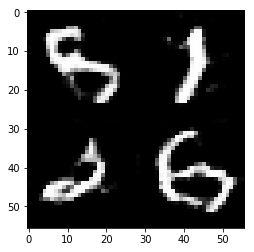

Epoch 2/2... Discriminator Loss: 0.7220... Generator Loss: 0.9861
Epoch 2/2... Discriminator Loss: 0.2801... Generator Loss: 1.9153
Epoch 2/2... Discriminator Loss: 0.6132... Generator Loss: 1.2134
Epoch 2/2... Discriminator Loss: 0.9871... Generator Loss: 0.6521
Epoch 2/2... Discriminator Loss: 1.5854... Generator Loss: 0.3878
Epoch 2/2... Discriminator Loss: 0.2911... Generator Loss: 1.9875
Epoch 2/2... Discriminator Loss: 1.4176... Generator Loss: 0.4405
Epoch 2/2... Discriminator Loss: 0.6393... Generator Loss: 1.2154
Epoch 2/2... Discriminator Loss: 0.6229... Generator Loss: 1.0075
Epoch 2/2... Discriminator Loss: 0.3477... Generator Loss: 2.0431


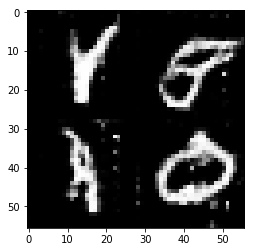

Epoch 2/2... Discriminator Loss: 1.1130... Generator Loss: 0.6214
Epoch 2/2... Discriminator Loss: 1.8596... Generator Loss: 0.3535
Epoch 2/2... Discriminator Loss: 0.0821... Generator Loss: 3.8227
Epoch 2/2... Discriminator Loss: 1.5470... Generator Loss: 0.4006
Epoch 2/2... Discriminator Loss: 0.9031... Generator Loss: 0.8910
Epoch 2/2... Discriminator Loss: 0.8960... Generator Loss: 0.7824
Epoch 2/2... Discriminator Loss: 0.4951... Generator Loss: 1.4601
Epoch 2/2... Discriminator Loss: 0.1811... Generator Loss: 3.4941
Epoch 2/2... Discriminator Loss: 1.1511... Generator Loss: 0.6427
Epoch 2/2... Discriminator Loss: 1.1449... Generator Loss: 0.5908


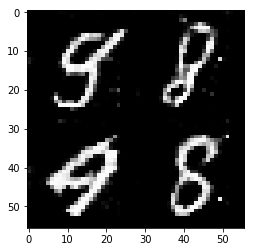

Epoch 2/2... Discriminator Loss: 0.4908... Generator Loss: 1.2156
Epoch 2/2... Discriminator Loss: 0.5750... Generator Loss: 1.2392
Epoch 2/2... Discriminator Loss: 0.3792... Generator Loss: 1.4738
Epoch 2/2... Discriminator Loss: 0.3689... Generator Loss: 2.0156
Epoch 2/2... Discriminator Loss: 0.3465... Generator Loss: 1.9222
Epoch 2/2... Discriminator Loss: 0.4649... Generator Loss: 1.8773
Epoch 2/2... Discriminator Loss: 0.5483... Generator Loss: 1.1067
Epoch 2/2... Discriminator Loss: 0.6461... Generator Loss: 1.0317
Epoch 2/2... Discriminator Loss: 0.6229... Generator Loss: 1.1435
Epoch 2/2... Discriminator Loss: 0.2313... Generator Loss: 7.6940


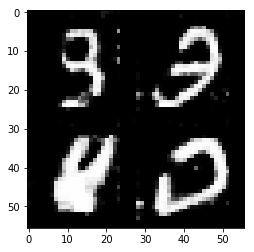

Epoch 2/2... Discriminator Loss: 0.6399... Generator Loss: 1.1688
Epoch 2/2... Discriminator Loss: 0.4329... Generator Loss: 2.1846
Epoch 2/2... Discriminator Loss: 0.5021... Generator Loss: 1.3647
Epoch 2/2... Discriminator Loss: 1.8647... Generator Loss: 0.2924
Epoch 2/2... Discriminator Loss: 0.2946... Generator Loss: 1.8111
Epoch 2/2... Discriminator Loss: 0.7861... Generator Loss: 1.1250
Epoch 2/2... Discriminator Loss: 1.7165... Generator Loss: 0.4010
Epoch 2/2... Discriminator Loss: 0.8919... Generator Loss: 0.7433
Epoch 2/2... Discriminator Loss: 0.4599... Generator Loss: 1.3794
Epoch 2/2... Discriminator Loss: 0.3920... Generator Loss: 1.6864


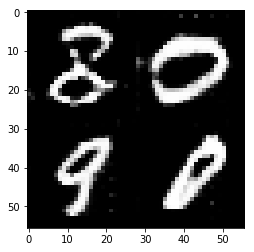

Epoch 2/2... Discriminator Loss: 0.3392... Generator Loss: 1.9475
Epoch 2/2... Discriminator Loss: 1.4963... Generator Loss: 0.3856
Epoch 2/2... Discriminator Loss: 0.5600... Generator Loss: 1.5601
Epoch 2/2... Discriminator Loss: 0.2282... Generator Loss: 5.5941
Epoch 2/2... Discriminator Loss: 2.3571... Generator Loss: 0.2346
Epoch 2/2... Discriminator Loss: 0.1370... Generator Loss: 3.3528
Epoch 2/2... Discriminator Loss: 0.0258... Generator Loss: 4.7135
Epoch 2/2... Discriminator Loss: 0.3279... Generator Loss: 1.8453
Epoch 2/2... Discriminator Loss: 1.1010... Generator Loss: 0.5175
Epoch 2/2... Discriminator Loss: 0.7447... Generator Loss: 0.9654


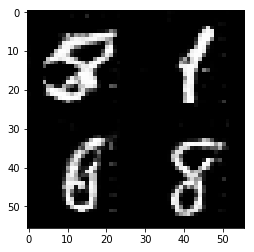

Epoch 2/2... Discriminator Loss: 0.2691... Generator Loss: 1.8038
Epoch 2/2... Discriminator Loss: 0.1512... Generator Loss: 2.4350
Epoch 2/2... Discriminator Loss: 0.1829... Generator Loss: 2.3996
Epoch 2/2... Discriminator Loss: 0.7334... Generator Loss: 1.1125
Epoch 2/2... Discriminator Loss: 0.2586... Generator Loss: 2.1634
Epoch 2/2... Discriminator Loss: 0.0989... Generator Loss: 3.0083
Epoch 2/2... Discriminator Loss: 0.1238... Generator Loss: 2.5524
Epoch 2/2... Discriminator Loss: 0.2182... Generator Loss: 2.5072
Epoch 2/2... Discriminator Loss: 0.7717... Generator Loss: 1.1146
Epoch 2/2... Discriminator Loss: 0.8142... Generator Loss: 1.6235


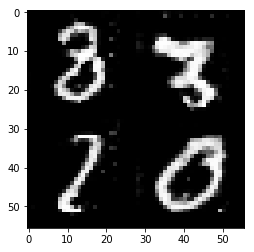

Epoch 2/2... Discriminator Loss: 0.3505... Generator Loss: 1.6250
Epoch 2/2... Discriminator Loss: 0.8647... Generator Loss: 0.8289
Epoch 2/2... Discriminator Loss: 0.2126... Generator Loss: 3.0721
Epoch 2/2... Discriminator Loss: 0.1166... Generator Loss: 2.6133
Epoch 2/2... Discriminator Loss: 0.3578... Generator Loss: 1.6957
Epoch 2/2... Discriminator Loss: 0.0288... Generator Loss: 5.5160
Epoch 2/2... Discriminator Loss: 0.5092... Generator Loss: 1.2080
Epoch 2/2... Discriminator Loss: 0.5279... Generator Loss: 1.7317
Epoch 2/2... Discriminator Loss: 1.4049... Generator Loss: 0.3821
Epoch 2/2... Discriminator Loss: 1.0342... Generator Loss: 0.6989


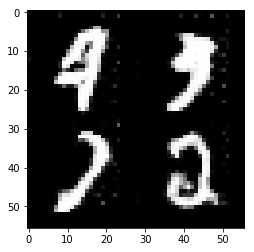

Epoch 2/2... Discriminator Loss: 0.0218... Generator Loss: 5.1775
Epoch 2/2... Discriminator Loss: 0.5066... Generator Loss: 1.3255
Epoch 2/2... Discriminator Loss: 0.4594... Generator Loss: 1.2790
Epoch 2/2... Discriminator Loss: 0.5220... Generator Loss: 1.1830
Epoch 2/2... Discriminator Loss: 0.1553... Generator Loss: 2.5088
Epoch 2/2... Discriminator Loss: 1.7541... Generator Loss: 0.2608
Epoch 2/2... Discriminator Loss: 2.1465... Generator Loss: 0.2257
Epoch 2/2... Discriminator Loss: 0.2565... Generator Loss: 2.5467
Epoch 2/2... Discriminator Loss: 0.8049... Generator Loss: 0.6926
Epoch 2/2... Discriminator Loss: 0.3339... Generator Loss: 9.0984


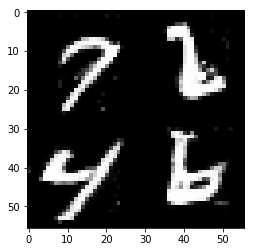

Epoch 2/2... Discriminator Loss: 0.7369... Generator Loss: 0.8156
Epoch 2/2... Discriminator Loss: 0.2272... Generator Loss: 2.6677
Epoch 2/2... Discriminator Loss: 1.3944... Generator Loss: 0.6591
Epoch 2/2... Discriminator Loss: 0.0751... Generator Loss: 3.5454
Epoch 2/2... Discriminator Loss: 0.6017... Generator Loss: 1.0414
Epoch 2/2... Discriminator Loss: 0.3196... Generator Loss: 1.7621
Epoch 2/2... Discriminator Loss: 1.1678... Generator Loss: 0.6590
Epoch 2/2... Discriminator Loss: 0.9511... Generator Loss: 0.8351
Epoch 2/2... Discriminator Loss: 0.0988... Generator Loss: 3.4422
Epoch 2/2... Discriminator Loss: 0.1236... Generator Loss: 4.2928


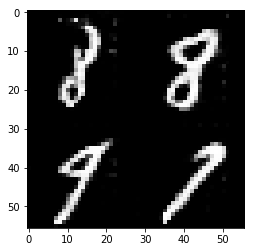

Epoch 2/2... Discriminator Loss: 0.5364... Generator Loss: 1.3353
Epoch 2/2... Discriminator Loss: 0.5453... Generator Loss: 1.4059
Epoch 2/2... Discriminator Loss: 0.3985... Generator Loss: 8.3399
Epoch 2/2... Discriminator Loss: 0.3341... Generator Loss: 2.2423
Epoch 2/2... Discriminator Loss: 0.1390... Generator Loss: 2.6248
Epoch 2/2... Discriminator Loss: 0.1842... Generator Loss: 2.2761
Epoch 2/2... Discriminator Loss: 0.4892... Generator Loss: 1.3243
Epoch 2/2... Discriminator Loss: 0.3265... Generator Loss: 2.2529
Epoch 2/2... Discriminator Loss: 0.2751... Generator Loss: 1.8639
Epoch 2/2... Discriminator Loss: 0.7356... Generator Loss: 0.9103


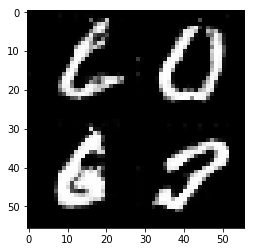

Epoch 2/2... Discriminator Loss: 0.4776... Generator Loss: 1.3732
Epoch 2/2... Discriminator Loss: 1.4615... Generator Loss: 0.8314
Epoch 2/2... Discriminator Loss: 0.4667... Generator Loss: 1.2155
Epoch 2/2... Discriminator Loss: 0.0515... Generator Loss: 3.9811
Epoch 2/2... Discriminator Loss: 1.6506... Generator Loss: 0.3610
Epoch 2/2... Discriminator Loss: 2.9766... Generator Loss: 0.0829
Epoch 2/2... Discriminator Loss: 1.8470... Generator Loss: 0.4331
Epoch 2/2... Discriminator Loss: 1.1273... Generator Loss: 0.8690
Epoch 2/2... Discriminator Loss: 1.0124... Generator Loss: 0.6285
Epoch 2/2... Discriminator Loss: 0.7312... Generator Loss: 0.9949


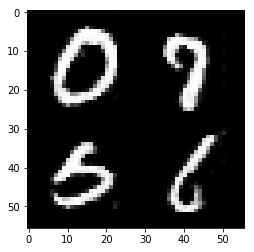

Epoch 2/2... Discriminator Loss: 1.6468... Generator Loss: 0.3245
Epoch 2/2... Discriminator Loss: 1.4306... Generator Loss: 0.6576
Epoch 2/2... Discriminator Loss: 0.5796... Generator Loss: 1.2924
Epoch 2/2... Discriminator Loss: 0.2395... Generator Loss: 3.6348
Epoch 2/2... Discriminator Loss: 0.4715... Generator Loss: 2.7792
Epoch 2/2... Discriminator Loss: 0.2100... Generator Loss: 2.6153
Epoch 2/2... Discriminator Loss: 0.0766... Generator Loss: 2.9312
Epoch 2/2... Discriminator Loss: 2.9483... Generator Loss: 0.1033
Epoch 2/2... Discriminator Loss: 0.9134... Generator Loss: 0.9085
Epoch 2/2... Discriminator Loss: 0.0952... Generator Loss: 5.9342


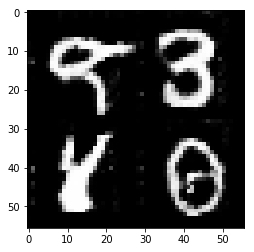

Epoch 2/2... Discriminator Loss: 0.2182... Generator Loss: 3.4234
Epoch 2/2... Discriminator Loss: 0.4601... Generator Loss: 5.0432
Epoch 2/2... Discriminator Loss: 0.3651... Generator Loss: 1.9828
Epoch 2/2... Discriminator Loss: 0.2931... Generator Loss: 1.7233
Epoch 2/2... Discriminator Loss: 0.7219... Generator Loss: 0.9546
Epoch 2/2... Discriminator Loss: 0.4290... Generator Loss: 1.4432
Epoch 2/2... Discriminator Loss: 0.2972... Generator Loss: 2.4320
Epoch 2/2... Discriminator Loss: 0.7908... Generator Loss: 1.0889
Epoch 2/2... Discriminator Loss: 0.3451... Generator Loss: 1.8654
Epoch 2/2... Discriminator Loss: 0.5232... Generator Loss: 1.1358


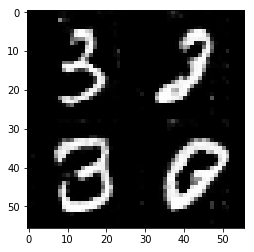

Epoch 2/2... Discriminator Loss: 1.9315... Generator Loss: 0.2978
Epoch 2/2... Discriminator Loss: 0.3398... Generator Loss: 1.6703
Epoch 2/2... Discriminator Loss: 1.0699... Generator Loss: 0.6590
Epoch 2/2... Discriminator Loss: 0.8064... Generator Loss: 0.8946
Epoch 2/2... Discriminator Loss: 0.2049... Generator Loss: 2.6087
Epoch 2/2... Discriminator Loss: 0.9887... Generator Loss: 0.5754
Epoch 2/2... Discriminator Loss: 0.0583... Generator Loss: 5.8878
Epoch 2/2... Discriminator Loss: 0.3083... Generator Loss: 1.5953
Epoch 2/2... Discriminator Loss: 1.5154... Generator Loss: 0.6235
Epoch 2/2... Discriminator Loss: 3.5362... Generator Loss: 0.0578


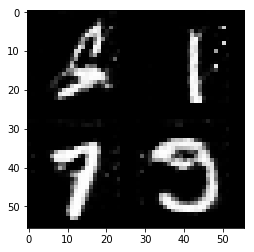

Epoch 2/2... Discriminator Loss: 1.9269... Generator Loss: 0.3592
Epoch 2/2... Discriminator Loss: 0.2077... Generator Loss: 4.5994
Epoch 2/2... Discriminator Loss: 0.0657... Generator Loss: 3.6812
Epoch 2/2... Discriminator Loss: 0.9106... Generator Loss: 0.8692
Epoch 2/2... Discriminator Loss: 0.2935... Generator Loss: 1.7592
Epoch 2/2... Discriminator Loss: 1.0100... Generator Loss: 0.9190
Epoch 2/2... Discriminator Loss: 0.1768... Generator Loss: 4.5860
Epoch 2/2... Discriminator Loss: 0.1803... Generator Loss: 2.3937
Epoch 2/2... Discriminator Loss: 0.7989... Generator Loss: 0.8160
Epoch 2/2... Discriminator Loss: 1.3801... Generator Loss: 0.4122


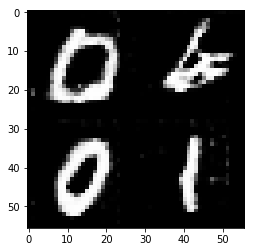

Epoch 2/2... Discriminator Loss: 1.1881... Generator Loss: 0.7000
Epoch 2/2... Discriminator Loss: 0.7087... Generator Loss: 0.8674
Epoch 2/2... Discriminator Loss: 0.4669... Generator Loss: 1.2278
Epoch 2/2... Discriminator Loss: 0.0481... Generator Loss: 3.6056
Epoch 2/2... Discriminator Loss: 1.0337... Generator Loss: 0.6671
Epoch 2/2... Discriminator Loss: 0.7001... Generator Loss: 0.8995
Epoch 2/2... Discriminator Loss: 0.2081... Generator Loss: 2.1627
Epoch 2/2... Discriminator Loss: 0.9215... Generator Loss: 0.7615
Epoch 2/2... Discriminator Loss: 0.4445... Generator Loss: 1.4126
Epoch 2/2... Discriminator Loss: 1.5996... Generator Loss: 0.3422


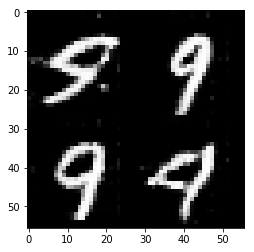

Epoch 2/2... Discriminator Loss: 0.1080... Generator Loss: 2.9278
Epoch 2/2... Discriminator Loss: 0.0300... Generator Loss: 4.1680
Epoch 2/2... Discriminator Loss: 0.2785... Generator Loss: 1.8111
Epoch 2/2... Discriminator Loss: 0.1167... Generator Loss: 2.3921
Epoch 2/2... Discriminator Loss: 0.5656... Generator Loss: 0.9710
Epoch 2/2... Discriminator Loss: 0.1225... Generator Loss: 2.4553
Epoch 2/2... Discriminator Loss: 0.1891... Generator Loss: 1.9094
Epoch 2/2... Discriminator Loss: 2.4202... Generator Loss: 0.1175
Epoch 2/2... Discriminator Loss: 0.8517... Generator Loss: 0.8075
Epoch 2/2... Discriminator Loss: 0.1139... Generator Loss: 3.3450


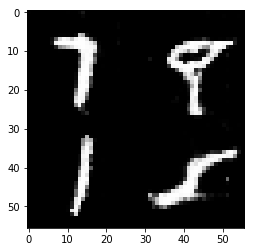

Epoch 2/2... Discriminator Loss: 0.2806... Generator Loss: 2.0862
Epoch 2/2... Discriminator Loss: 1.8298... Generator Loss: 0.3430
Epoch 2/2... Discriminator Loss: 0.4765... Generator Loss: 1.4469
Epoch 2/2... Discriminator Loss: 0.5449... Generator Loss: 1.2236
Epoch 2/2... Discriminator Loss: 1.3402... Generator Loss: 0.4604
Epoch 2/2... Discriminator Loss: 0.6546... Generator Loss: 1.2638
Epoch 2/2... Discriminator Loss: 0.6585... Generator Loss: 1.2716
Epoch 2/2... Discriminator Loss: 0.3635... Generator Loss: 1.6322
Epoch 2/2... Discriminator Loss: 0.2835... Generator Loss: 1.9820
Epoch 2/2... Discriminator Loss: 0.4703... Generator Loss: 1.2700


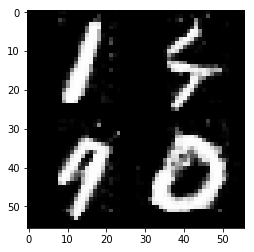

Epoch 2/2... Discriminator Loss: 0.0635... Generator Loss: 7.3501
Epoch 2/2... Discriminator Loss: 0.4078... Generator Loss: 1.5826
Epoch 2/2... Discriminator Loss: 0.7184... Generator Loss: 0.9625
Epoch 2/2... Discriminator Loss: 0.9916... Generator Loss: 0.6809
Epoch 2/2... Discriminator Loss: 0.4310... Generator Loss: 1.1982
Epoch 2/2... Discriminator Loss: 0.0259... Generator Loss: 4.8050
Epoch 2/2... Discriminator Loss: 1.0015... Generator Loss: 0.6488
Epoch 2/2... Discriminator Loss: 1.9101... Generator Loss: 0.3463
Epoch 2/2... Discriminator Loss: 0.8543... Generator Loss: 0.8028
Epoch 2/2... Discriminator Loss: 0.1378... Generator Loss: 2.8094


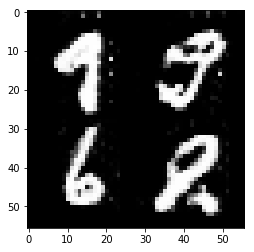

Epoch 2/2... Discriminator Loss: 3.3135... Generator Loss: 0.0851
Epoch 2/2... Discriminator Loss: 4.3191... Generator Loss: 0.0436
Epoch 2/2... Discriminator Loss: 0.9914... Generator Loss: 0.9913
Epoch 2/2... Discriminator Loss: 0.2422... Generator Loss: 1.8973
Epoch 2/2... Discriminator Loss: 0.4690... Generator Loss: 1.4413
Epoch 2/2... Discriminator Loss: 0.3087... Generator Loss: 1.8583
Epoch 2/2... Discriminator Loss: 0.1979... Generator Loss: 3.6768
Epoch 2/2... Discriminator Loss: 0.8938... Generator Loss: 0.7912
Epoch 2/2... Discriminator Loss: 0.4950... Generator Loss: 1.2000
Epoch 2/2... Discriminator Loss: 0.3754... Generator Loss: 1.5263


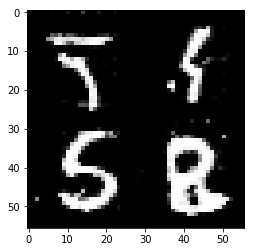

Epoch 2/2... Discriminator Loss: 0.0961... Generator Loss: 2.7619
Epoch 2/2... Discriminator Loss: 0.1444... Generator Loss: 2.6387
Epoch 2/2... Discriminator Loss: 0.1548... Generator Loss: 4.6740
Epoch 2/2... Discriminator Loss: 0.5364... Generator Loss: 2.1362
Epoch 2/2... Discriminator Loss: 0.0089... Generator Loss: 5.3676
Epoch 2/2... Discriminator Loss: 0.3026... Generator Loss: 2.4215
Epoch 2/2... Discriminator Loss: 0.0309... Generator Loss: 5.7161
Epoch 2/2... Discriminator Loss: 0.2100... Generator Loss: 2.9806
Epoch 2/2... Discriminator Loss: 0.5295... Generator Loss: 1.7706
Epoch 2/2... Discriminator Loss: 2.1578... Generator Loss: 0.2532


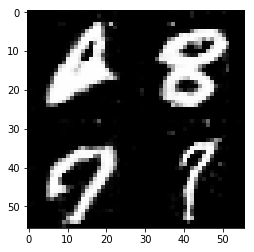

Epoch 2/2... Discriminator Loss: 1.4375... Generator Loss: 0.3327
Epoch 2/2... Discriminator Loss: 0.0739... Generator Loss: 6.1787
Epoch 2/2... Discriminator Loss: 0.3021... Generator Loss: 1.8230
Epoch 2/2... Discriminator Loss: 1.2249... Generator Loss: 0.7497
Epoch 2/2... Discriminator Loss: 0.1061... Generator Loss: 4.8374
Epoch 2/2... Discriminator Loss: 2.3592... Generator Loss: 0.2033
Epoch 2/2... Discriminator Loss: 2.2679... Generator Loss: 0.2023
Epoch 2/2... Discriminator Loss: 1.4171... Generator Loss: 0.4974
Epoch 2/2... Discriminator Loss: 0.9562... Generator Loss: 0.6197
Epoch 2/2... Discriminator Loss: 2.9901... Generator Loss: 0.0856


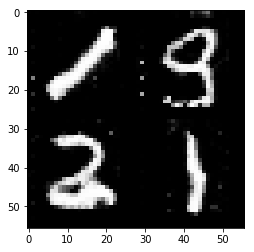

Epoch 2/2... Discriminator Loss: 0.0905... Generator Loss: 2.9942
Epoch 2/2... Discriminator Loss: 0.0282... Generator Loss: 6.6417
Epoch 2/2... Discriminator Loss: 0.1786... Generator Loss: 3.2521
Epoch 2/2... Discriminator Loss: 0.3428... Generator Loss: 1.6997
Epoch 2/2... Discriminator Loss: 1.1265... Generator Loss: 0.5190
Epoch 2/2... Discriminator Loss: 0.1612... Generator Loss: 2.2813
Epoch 2/2... Discriminator Loss: 1.2043... Generator Loss: 0.5185
Epoch 2/2... Discriminator Loss: 1.3173... Generator Loss: 0.5212
Epoch 2/2... Discriminator Loss: 0.5945... Generator Loss: 1.1327
Epoch 2/2... Discriminator Loss: 0.3482... Generator Loss: 1.5278


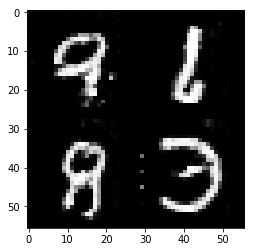

Epoch 2/2... Discriminator Loss: 0.0472... Generator Loss: 3.7793
Epoch 2/2... Discriminator Loss: 0.3959... Generator Loss: 1.5919
Epoch 2/2... Discriminator Loss: 0.0588... Generator Loss: 3.3315
Epoch 2/2... Discriminator Loss: 1.4466... Generator Loss: 0.3797
Epoch 2/2... Discriminator Loss: 1.0805... Generator Loss: 0.7523
Epoch 2/2... Discriminator Loss: 0.9140... Generator Loss: 0.8220
Epoch 2/2... Discriminator Loss: 0.3731... Generator Loss: 1.4253
Epoch 2/2... Discriminator Loss: 0.5457... Generator Loss: 1.0935
Epoch 2/2... Discriminator Loss: 0.9079... Generator Loss: 0.8025
Epoch 2/2... Discriminator Loss: 1.0562... Generator Loss: 0.6241


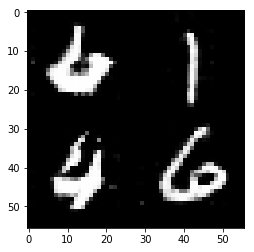

Epoch 2/2... Discriminator Loss: 0.8974... Generator Loss: 0.6747
Epoch 2/2... Discriminator Loss: 0.2538... Generator Loss: 1.7019
Epoch 2/2... Discriminator Loss: 0.0432... Generator Loss: 5.5960
Epoch 2/2... Discriminator Loss: 0.1470... Generator Loss: 5.3276
Epoch 2/2... Discriminator Loss: 0.0465... Generator Loss: 4.2121
Epoch 2/2... Discriminator Loss: 0.1056... Generator Loss: 2.9917
Epoch 2/2... Discriminator Loss: 0.8567... Generator Loss: 0.7063
Epoch 2/2... Discriminator Loss: 0.9713... Generator Loss: 1.1634
Epoch 2/2... Discriminator Loss: 0.1301... Generator Loss: 3.0217
Epoch 2/2... Discriminator Loss: 0.8862... Generator Loss: 0.7572


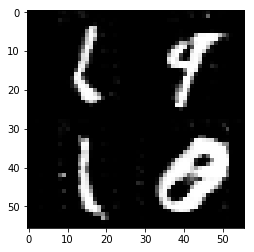

Epoch 2/2... Discriminator Loss: 0.1792... Generator Loss: 2.0457
Epoch 2/2... Discriminator Loss: 3.4110... Generator Loss: 0.0784
Epoch 2/2... Discriminator Loss: 0.2673... Generator Loss: 2.3649
Epoch 2/2... Discriminator Loss: 0.1812... Generator Loss: 2.2899
Epoch 2/2... Discriminator Loss: 0.3789... Generator Loss: 1.9079
Epoch 2/2... Discriminator Loss: 0.8931... Generator Loss: 0.8132
Epoch 2/2... Discriminator Loss: 0.4649... Generator Loss: 1.6243
Epoch 2/2... Discriminator Loss: 0.1025... Generator Loss: 3.3224
Epoch 2/2... Discriminator Loss: 1.4712... Generator Loss: 0.4659
Epoch 2/2... Discriminator Loss: 0.2840... Generator Loss: 1.7877


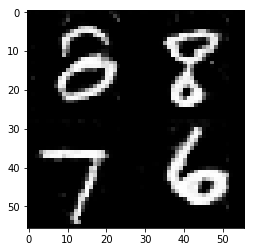

Epoch 2/2... Discriminator Loss: 0.3595... Generator Loss: 1.5984
Epoch 2/2... Discriminator Loss: 1.9484... Generator Loss: 0.1925
Epoch 2/2... Discriminator Loss: 0.1505... Generator Loss: 7.1138
Epoch 2/2... Discriminator Loss: 0.0332... Generator Loss: 3.8948
Epoch 2/2... Discriminator Loss: 0.6970... Generator Loss: 0.9746
Epoch 2/2... Discriminator Loss: 0.3592... Generator Loss: 2.1024
Epoch 2/2... Discriminator Loss: 5.0024... Generator Loss: 7.7950
Epoch 2/2... Discriminator Loss: 0.1084... Generator Loss: 4.2886
Epoch 2/2... Discriminator Loss: 1.1251... Generator Loss: 0.8977
Epoch 2/2... Discriminator Loss: 0.8484... Generator Loss: 0.8459


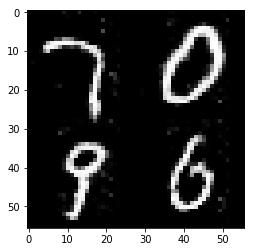

Epoch 2/2... Discriminator Loss: 0.3885... Generator Loss: 1.6251
Epoch 2/2... Discriminator Loss: 0.4911... Generator Loss: 3.6562
Epoch 2/2... Discriminator Loss: 0.4941... Generator Loss: 1.2323
Epoch 2/2... Discriminator Loss: 1.6075... Generator Loss: 0.4565
Epoch 2/2... Discriminator Loss: 1.9905... Generator Loss: 0.2371
Epoch 2/2... Discriminator Loss: 0.7190... Generator Loss: 0.9104
Epoch 2/2... Discriminator Loss: 0.1419... Generator Loss: 2.8703
Epoch 2/2... Discriminator Loss: 1.1160... Generator Loss: 0.9845
Epoch 2/2... Discriminator Loss: 0.2609... Generator Loss: 2.3883
Epoch 2/2... Discriminator Loss: 0.9835... Generator Loss: 0.7035


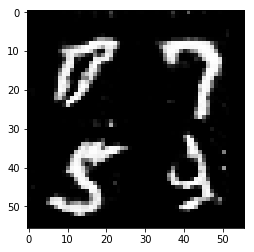

Epoch 2/2... Discriminator Loss: 0.4306... Generator Loss: 1.5794
Epoch 2/2... Discriminator Loss: 0.4071... Generator Loss: 1.7795
Epoch 2/2... Discriminator Loss: 1.3212... Generator Loss: 0.5934
Epoch 2/2... Discriminator Loss: 0.5093... Generator Loss: 1.5090
Epoch 2/2... Discriminator Loss: 0.8923... Generator Loss: 0.8754
Epoch 2/2... Discriminator Loss: 0.8135... Generator Loss: 0.7533
Epoch 2/2... Discriminator Loss: 0.0464... Generator Loss: 4.3680
Epoch 2/2... Discriminator Loss: 0.7889... Generator Loss: 1.1664
Epoch 2/2... Discriminator Loss: 0.4841... Generator Loss: 1.2199
Epoch 2/2... Discriminator Loss: 0.0340... Generator Loss: 5.4724


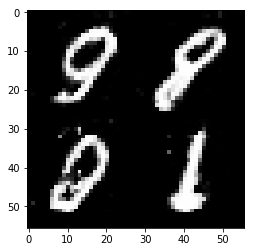

Epoch 2/2... Discriminator Loss: 0.2070... Generator Loss: 2.4525
Epoch 2/2... Discriminator Loss: 0.0775... Generator Loss: 3.4545
Epoch 2/2... Discriminator Loss: 0.0572... Generator Loss: 4.0604
Epoch 2/2... Discriminator Loss: 0.1523... Generator Loss: 2.2871
Epoch 2/2... Discriminator Loss: 2.3272... Generator Loss: 8.1690
Epoch 2/2... Discriminator Loss: 0.5435... Generator Loss: 1.3442
Epoch 2/2... Discriminator Loss: 0.6196... Generator Loss: 1.0367
Epoch 2/2... Discriminator Loss: 0.6449... Generator Loss: 1.0757
Epoch 2/2... Discriminator Loss: 1.2181... Generator Loss: 0.5143
Epoch 2/2... Discriminator Loss: 0.0281... Generator Loss: 4.9033


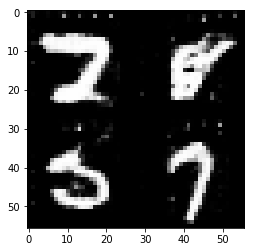

Epoch 2/2... Discriminator Loss: 0.6281... Generator Loss: 1.0602
Epoch 2/2... Discriminator Loss: 1.2972... Generator Loss: 0.4383
Epoch 2/2... Discriminator Loss: 0.6740... Generator Loss: 1.6477
Epoch 2/2... Discriminator Loss: 0.3569... Generator Loss: 1.4875
Epoch 2/2... Discriminator Loss: 0.1832... Generator Loss: 3.0275
Epoch 2/2... Discriminator Loss: 0.0882... Generator Loss: 3.1105
Epoch 2/2... Discriminator Loss: 0.0439... Generator Loss: 3.8949
Epoch 2/2... Discriminator Loss: 0.1854... Generator Loss: 2.3946
Epoch 2/2... Discriminator Loss: 0.5983... Generator Loss: 1.1571
Epoch 2/2... Discriminator Loss: 1.8867... Generator Loss: 0.3128


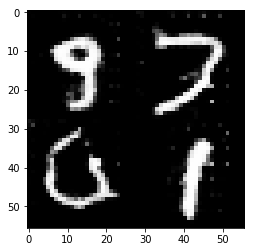

Epoch 2/2... Discriminator Loss: 0.6591... Generator Loss: 1.0841
Epoch 2/2... Discriminator Loss: 0.0591... Generator Loss: 4.5250
Epoch 2/2... Discriminator Loss: 0.6485... Generator Loss: 1.2515
Epoch 2/2... Discriminator Loss: 0.1909... Generator Loss: 2.6562
Epoch 2/2... Discriminator Loss: 0.8439... Generator Loss: 0.8599
Epoch 2/2... Discriminator Loss: 0.3574... Generator Loss: 2.4881
Epoch 2/2... Discriminator Loss: 0.1589... Generator Loss: 4.0431
Epoch 2/2... Discriminator Loss: 2.2780... Generator Loss: 0.2072
Epoch 2/2... Discriminator Loss: 0.0288... Generator Loss: 4.3722
Epoch 2/2... Discriminator Loss: 0.3133... Generator Loss: 1.8968


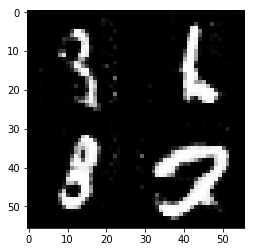

Epoch 2/2... Discriminator Loss: 0.0445... Generator Loss: 3.8856
Epoch 2/2... Discriminator Loss: 0.4897... Generator Loss: 1.5114
Epoch 2/2... Discriminator Loss: 0.4545... Generator Loss: 1.5695
Epoch 2/2... Discriminator Loss: 1.7284... Generator Loss: 0.4151
Epoch 2/2... Discriminator Loss: 1.1606... Generator Loss: 7.8808
Epoch 2/2... Discriminator Loss: 0.0123... Generator Loss: 5.2046
Epoch 2/2... Discriminator Loss: 0.0976... Generator Loss: 5.3517
Epoch 2/2... Discriminator Loss: 0.6383... Generator Loss: 1.0346
Epoch 2/2... Discriminator Loss: 0.4699... Generator Loss: 1.8108
Epoch 2/2... Discriminator Loss: 0.3241... Generator Loss: 1.8062


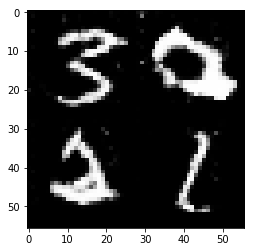

Epoch 2/2... Discriminator Loss: 0.3041... Generator Loss: 2.4351
Epoch 2/2... Discriminator Loss: 0.0961... Generator Loss: 3.1704
Epoch 2/2... Discriminator Loss: 1.4517... Generator Loss: 0.4128
Epoch 2/2... Discriminator Loss: 3.2470... Generator Loss: 0.0577
Epoch 2/2... Discriminator Loss: 1.7494... Generator Loss: 0.3193
Epoch 2/2... Discriminator Loss: 2.2000... Generator Loss: 0.1686
Epoch 2/2... Discriminator Loss: 0.1989... Generator Loss: 2.2614
Epoch 2/2... Discriminator Loss: 0.2876... Generator Loss: 6.1343
Epoch 2/2... Discriminator Loss: 0.7195... Generator Loss: 0.9904
Epoch 2/2... Discriminator Loss: 0.1804... Generator Loss: 3.0187


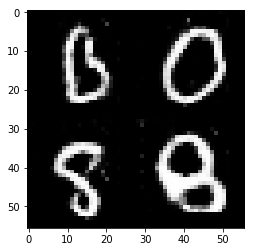

Epoch 2/2... Discriminator Loss: 0.2959... Generator Loss: 1.5436
Epoch 2/2... Discriminator Loss: 0.2918... Generator Loss: 2.6418
Epoch 2/2... Discriminator Loss: 0.9248... Generator Loss: 0.7955
Epoch 2/2... Discriminator Loss: 0.2918... Generator Loss: 1.9203
Epoch 2/2... Discriminator Loss: 0.0619... Generator Loss: 3.5749
Epoch 2/2... Discriminator Loss: 1.0580... Generator Loss: 0.7091
Epoch 2/2... Discriminator Loss: 0.9945... Generator Loss: 0.7235
Epoch 2/2... Discriminator Loss: 1.2421... Generator Loss: 1.4738
Epoch 2/2... Discriminator Loss: 0.9667... Generator Loss: 0.6078
Epoch 2/2... Discriminator Loss: 0.0552... Generator Loss: 3.5186


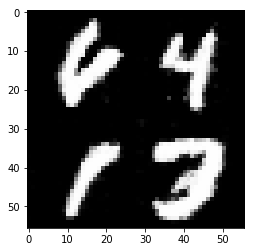

Epoch 2/2... Discriminator Loss: 0.1647... Generator Loss: 2.6917
Epoch 2/2... Discriminator Loss: 0.0253... Generator Loss: 4.7294
Epoch 2/2... Discriminator Loss: 0.0923... Generator Loss: 3.3167
Epoch 2/2... Discriminator Loss: 0.0346... Generator Loss: 4.2978
Epoch 2/2... Discriminator Loss: 0.1732... Generator Loss: 2.3438
Epoch 2/2... Discriminator Loss: 0.1101... Generator Loss: 2.9968
Epoch 2/2... Discriminator Loss: 0.0946... Generator Loss: 3.2920
Epoch 2/2... Discriminator Loss: 1.0724... Generator Loss: 0.6946
Epoch 2/2... Discriminator Loss: 1.4937... Generator Loss: 0.3709
Epoch 2/2... Discriminator Loss: 1.0514... Generator Loss: 0.5916


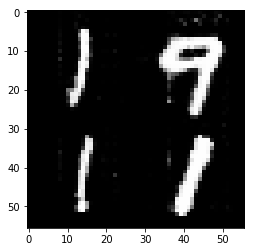

In [12]:
batch_size = 10
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2023... Generator Loss: 2.7201
Epoch 1/1... Discriminator Loss: 0.0926... Generator Loss: 3.0440
Epoch 1/1... Discriminator Loss: 0.0201... Generator Loss: 4.7688
Epoch 1/1... Discriminator Loss: 0.0054... Generator Loss: 10.6179
Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 8.5223
Epoch 1/1... Discriminator Loss: 0.2525... Generator Loss: 7.1320
Epoch 1/1... Discriminator Loss: 0.0324... Generator Loss: 6.5063
Epoch 1/1... Discriminator Loss: 0.0632... Generator Loss: 3.9195
Epoch 1/1... Discriminator Loss: 0.0302... Generator Loss: 5.0230
Epoch 1/1... Discriminator Loss: 0.0456... Generator Loss: 3.9810


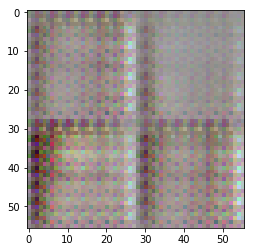

Epoch 1/1... Discriminator Loss: 0.0949... Generator Loss: 3.3264
Epoch 1/1... Discriminator Loss: 0.1366... Generator Loss: 3.9763
Epoch 1/1... Discriminator Loss: 0.4255... Generator Loss: 7.6527
Epoch 1/1... Discriminator Loss: 0.2518... Generator Loss: 3.2612
Epoch 1/1... Discriminator Loss: 0.1216... Generator Loss: 3.7016
Epoch 1/1... Discriminator Loss: 0.3411... Generator Loss: 4.4907
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 6.6860
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 8.5706
Epoch 1/1... Discriminator Loss: 0.1580... Generator Loss: 5.3710
Epoch 1/1... Discriminator Loss: 0.5992... Generator Loss: 1.6793


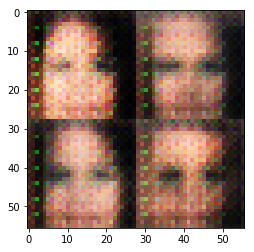

Epoch 1/1... Discriminator Loss: 0.2810... Generator Loss: 3.5523
Epoch 1/1... Discriminator Loss: 0.3544... Generator Loss: 5.3581
Epoch 1/1... Discriminator Loss: 0.2703... Generator Loss: 2.6095
Epoch 1/1... Discriminator Loss: 0.2078... Generator Loss: 3.2445
Epoch 1/1... Discriminator Loss: 0.0619... Generator Loss: 6.6690
Epoch 1/1... Discriminator Loss: 0.3594... Generator Loss: 12.7519
Epoch 1/1... Discriminator Loss: 0.2235... Generator Loss: 2.8330
Epoch 1/1... Discriminator Loss: 0.0943... Generator Loss: 3.8201
Epoch 1/1... Discriminator Loss: 0.0801... Generator Loss: 3.6822
Epoch 1/1... Discriminator Loss: 0.2473... Generator Loss: 2.8645


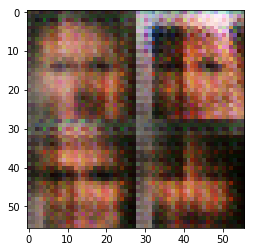

Epoch 1/1... Discriminator Loss: 0.1806... Generator Loss: 3.1659
Epoch 1/1... Discriminator Loss: 0.3457... Generator Loss: 1.9398
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 7.6417
Epoch 1/1... Discriminator Loss: 0.6589... Generator Loss: 1.1649
Epoch 1/1... Discriminator Loss: 0.2632... Generator Loss: 2.9751
Epoch 1/1... Discriminator Loss: 0.4118... Generator Loss: 2.6106
Epoch 1/1... Discriminator Loss: 0.3583... Generator Loss: 2.7724
Epoch 1/1... Discriminator Loss: 0.2573... Generator Loss: 3.0166
Epoch 1/1... Discriminator Loss: 0.2995... Generator Loss: 2.3107
Epoch 1/1... Discriminator Loss: 2.0757... Generator Loss: 0.3974


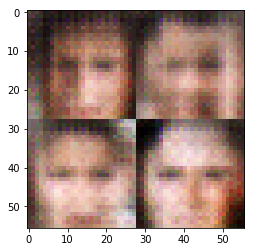

Epoch 1/1... Discriminator Loss: 0.5610... Generator Loss: 3.5183
Epoch 1/1... Discriminator Loss: 0.7384... Generator Loss: 1.2718
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 0.1418... Generator Loss: 3.7841
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 1.0451
Epoch 1/1... Discriminator Loss: 0.6131... Generator Loss: 1.6203
Epoch 1/1... Discriminator Loss: 1.7616... Generator Loss: 10.1251
Epoch 1/1... Discriminator Loss: 0.3238... Generator Loss: 2.1552
Epoch 1/1... Discriminator Loss: 0.1559... Generator Loss: 3.6650
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.5483


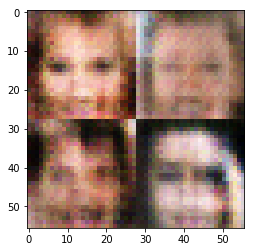

Epoch 1/1... Discriminator Loss: 0.3496... Generator Loss: 1.9625
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 1.0635
Epoch 1/1... Discriminator Loss: 0.5872... Generator Loss: 1.5239
Epoch 1/1... Discriminator Loss: 0.5819... Generator Loss: 1.6556
Epoch 1/1... Discriminator Loss: 0.5610... Generator Loss: 1.9155
Epoch 1/1... Discriminator Loss: 0.2684... Generator Loss: 2.6112
Epoch 1/1... Discriminator Loss: 0.4885... Generator Loss: 4.0564
Epoch 1/1... Discriminator Loss: 0.3088... Generator Loss: 2.6153
Epoch 1/1... Discriminator Loss: 0.5596... Generator Loss: 1.2893
Epoch 1/1... Discriminator Loss: 0.5663... Generator Loss: 1.3514


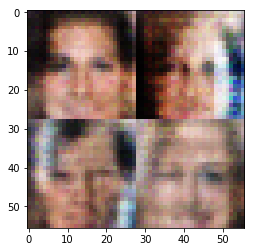

Epoch 1/1... Discriminator Loss: 0.4142... Generator Loss: 1.9661
Epoch 1/1... Discriminator Loss: 0.6582... Generator Loss: 1.3674
Epoch 1/1... Discriminator Loss: 0.8400... Generator Loss: 4.2144
Epoch 1/1... Discriminator Loss: 0.4638... Generator Loss: 2.2749
Epoch 1/1... Discriminator Loss: 0.3243... Generator Loss: 2.0473
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.5294
Epoch 1/1... Discriminator Loss: 0.7244... Generator Loss: 1.0893
Epoch 1/1... Discriminator Loss: 0.4661... Generator Loss: 1.5601
Epoch 1/1... Discriminator Loss: 0.6071... Generator Loss: 1.3533
Epoch 1/1... Discriminator Loss: 0.5086... Generator Loss: 2.3935


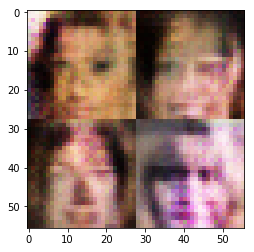

Epoch 1/1... Discriminator Loss: 0.3098... Generator Loss: 1.9872
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 0.6283... Generator Loss: 1.3840
Epoch 1/1... Discriminator Loss: 0.3676... Generator Loss: 2.0146
Epoch 1/1... Discriminator Loss: 0.5719... Generator Loss: 1.4410
Epoch 1/1... Discriminator Loss: 0.4091... Generator Loss: 2.7706
Epoch 1/1... Discriminator Loss: 0.3133... Generator Loss: 3.0337
Epoch 1/1... Discriminator Loss: 0.4300... Generator Loss: 1.8593
Epoch 1/1... Discriminator Loss: 0.4145... Generator Loss: 2.2423
Epoch 1/1... Discriminator Loss: 0.4890... Generator Loss: 1.6241


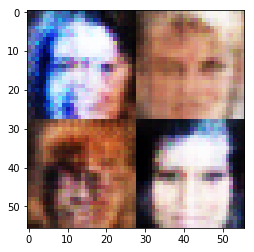

Epoch 1/1... Discriminator Loss: 0.4210... Generator Loss: 1.7730
Epoch 1/1... Discriminator Loss: 0.2756... Generator Loss: 2.7838
Epoch 1/1... Discriminator Loss: 0.3599... Generator Loss: 1.8296
Epoch 1/1... Discriminator Loss: 0.5119... Generator Loss: 2.5006
Epoch 1/1... Discriminator Loss: 0.3455... Generator Loss: 2.3891
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 0.7453... Generator Loss: 1.0358
Epoch 1/1... Discriminator Loss: 0.5556... Generator Loss: 1.4082
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 5.6465
Epoch 1/1... Discriminator Loss: 0.3852... Generator Loss: 1.5718


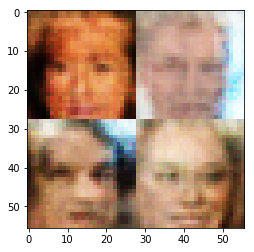

Epoch 1/1... Discriminator Loss: 0.5216... Generator Loss: 2.8908
Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 2.1393
Epoch 1/1... Discriminator Loss: 0.6437... Generator Loss: 1.0543
Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 0.4659... Generator Loss: 1.7804
Epoch 1/1... Discriminator Loss: 0.4994... Generator Loss: 1.5351
Epoch 1/1... Discriminator Loss: 0.5686... Generator Loss: 1.1958
Epoch 1/1... Discriminator Loss: 0.3903... Generator Loss: 1.8778
Epoch 1/1... Discriminator Loss: 0.4192... Generator Loss: 2.2577
Epoch 1/1... Discriminator Loss: 0.3192... Generator Loss: 2.1337


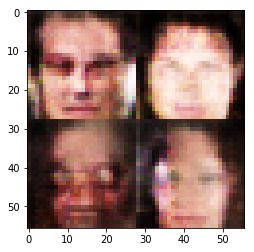

Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 4.0985
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.4562
Epoch 1/1... Discriminator Loss: 0.8932... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 0.3932... Generator Loss: 2.2231
Epoch 1/1... Discriminator Loss: 0.6411... Generator Loss: 4.1872
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 0.9247... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.5592
Epoch 1/1... Discriminator Loss: 0.4646... Generator Loss: 1.9315
Epoch 1/1... Discriminator Loss: 0.5034... Generator Loss: 1.5103


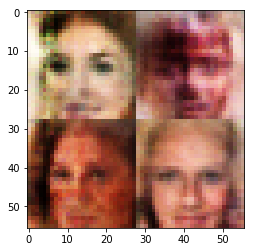

Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.4833
Epoch 1/1... Discriminator Loss: 0.5959... Generator Loss: 1.2244
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 0.6944... Generator Loss: 1.8092
Epoch 1/1... Discriminator Loss: 0.6025... Generator Loss: 1.2765
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 0.7619... Generator Loss: 0.9438
Epoch 1/1... Discriminator Loss: 0.4007... Generator Loss: 3.0011
Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 0.8080... Generator Loss: 0.8920


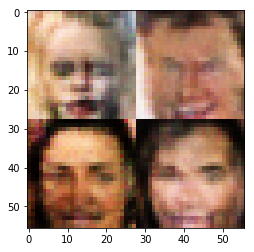

Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 0.6214... Generator Loss: 1.1361
Epoch 1/1... Discriminator Loss: 0.5057... Generator Loss: 1.8190
Epoch 1/1... Discriminator Loss: 0.4498... Generator Loss: 1.6106
Epoch 1/1... Discriminator Loss: 0.5733... Generator Loss: 2.1044
Epoch 1/1... Discriminator Loss: 0.8082... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 0.7406... Generator Loss: 1.0188
Epoch 1/1... Discriminator Loss: 0.8993... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 3.9506


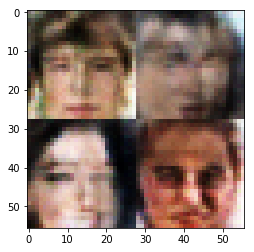

Epoch 1/1... Discriminator Loss: 0.8096... Generator Loss: 0.9881
Epoch 1/1... Discriminator Loss: 0.8918... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 0.8795... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 0.3983... Generator Loss: 2.1959
Epoch 1/1... Discriminator Loss: 0.5646... Generator Loss: 2.1172
Epoch 1/1... Discriminator Loss: 0.8054... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 0.6520... Generator Loss: 1.1195
Epoch 1/1... Discriminator Loss: 0.9479... Generator Loss: 3.6767
Epoch 1/1... Discriminator Loss: 0.4971... Generator Loss: 1.4577


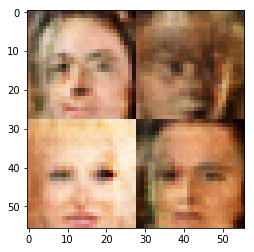

Epoch 1/1... Discriminator Loss: 0.6715... Generator Loss: 1.1163
Epoch 1/1... Discriminator Loss: 0.6162... Generator Loss: 1.1271
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 0.5244
Epoch 1/1... Discriminator Loss: 0.5283... Generator Loss: 2.3644
Epoch 1/1... Discriminator Loss: 0.5137... Generator Loss: 2.0091
Epoch 1/1... Discriminator Loss: 0.7170... Generator Loss: 1.1362
Epoch 1/1... Discriminator Loss: 0.5783... Generator Loss: 1.2681
Epoch 1/1... Discriminator Loss: 0.9587... Generator Loss: 4.2908
Epoch 1/1... Discriminator Loss: 0.7134... Generator Loss: 2.7990


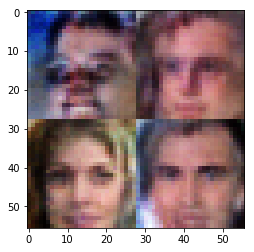

Epoch 1/1... Discriminator Loss: 0.9345... Generator Loss: 3.0866
Epoch 1/1... Discriminator Loss: 0.8818... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 0.7699... Generator Loss: 2.6378
Epoch 1/1... Discriminator Loss: 0.6167... Generator Loss: 1.2846
Epoch 1/1... Discriminator Loss: 0.4032... Generator Loss: 1.8129
Epoch 1/1... Discriminator Loss: 0.4742... Generator Loss: 2.3386
Epoch 1/1... Discriminator Loss: 0.5560... Generator Loss: 1.4165
Epoch 1/1... Discriminator Loss: 0.6563... Generator Loss: 1.2317
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.4490
Epoch 1/1... Discriminator Loss: 0.5556... Generator Loss: 1.7167


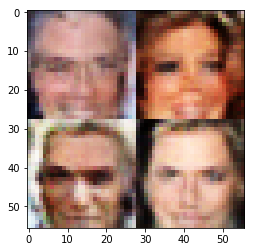

Epoch 1/1... Discriminator Loss: 0.9116... Generator Loss: 2.9001
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 3.5910
Epoch 1/1... Discriminator Loss: 0.4500... Generator Loss: 1.8233
Epoch 1/1... Discriminator Loss: 1.5104... Generator Loss: 0.4131
Epoch 1/1... Discriminator Loss: 0.3821... Generator Loss: 2.1905
Epoch 1/1... Discriminator Loss: 0.4222... Generator Loss: 1.6907
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 0.4771... Generator Loss: 3.4124
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.6470


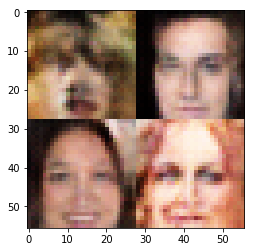

Epoch 1/1... Discriminator Loss: 0.8215... Generator Loss: 1.0124
Epoch 1/1... Discriminator Loss: 0.5023... Generator Loss: 1.6067
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 0.7839... Generator Loss: 1.8242
Epoch 1/1... Discriminator Loss: 0.9213... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 0.6212... Generator Loss: 2.7156
Epoch 1/1... Discriminator Loss: 0.5292... Generator Loss: 2.2932
Epoch 1/1... Discriminator Loss: 0.7373... Generator Loss: 1.9511
Epoch 1/1... Discriminator Loss: 1.6445... Generator Loss: 0.3117
Epoch 1/1... Discriminator Loss: 0.6776... Generator Loss: 2.1540


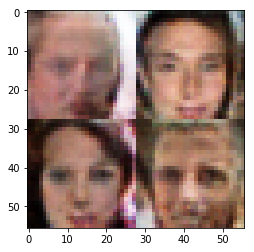

Epoch 1/1... Discriminator Loss: 0.5920... Generator Loss: 1.3771
Epoch 1/1... Discriminator Loss: 0.3601... Generator Loss: 1.8228
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 0.8376... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 0.7761... Generator Loss: 0.9621
Epoch 1/1... Discriminator Loss: 0.8749... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 0.7099... Generator Loss: 2.9425
Epoch 1/1... Discriminator Loss: 0.7679... Generator Loss: 1.2316
Epoch 1/1... Discriminator Loss: 0.6290... Generator Loss: 1.2943
Epoch 1/1... Discriminator Loss: 0.5934... Generator Loss: 2.0514


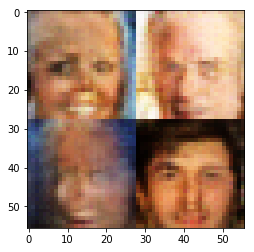

Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.4690
Epoch 1/1... Discriminator Loss: 0.9135... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 0.5484... Generator Loss: 1.7204
Epoch 1/1... Discriminator Loss: 0.8434... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.4636
Epoch 1/1... Discriminator Loss: 0.5974... Generator Loss: 1.6534
Epoch 1/1... Discriminator Loss: 0.7585... Generator Loss: 1.6518
Epoch 1/1... Discriminator Loss: 0.5797... Generator Loss: 1.3886


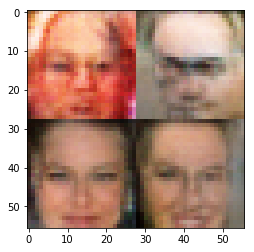

Epoch 1/1... Discriminator Loss: 0.6493... Generator Loss: 1.9791
Epoch 1/1... Discriminator Loss: 0.5101... Generator Loss: 1.2120
Epoch 1/1... Discriminator Loss: 1.6523... Generator Loss: 0.3120
Epoch 1/1... Discriminator Loss: 0.5562... Generator Loss: 2.3401
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 3.4960
Epoch 1/1... Discriminator Loss: 0.5688... Generator Loss: 1.5329
Epoch 1/1... Discriminator Loss: 0.6616... Generator Loss: 1.2531
Epoch 1/1... Discriminator Loss: 0.6567... Generator Loss: 1.1548
Epoch 1/1... Discriminator Loss: 0.6146... Generator Loss: 1.2540
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 0.6168


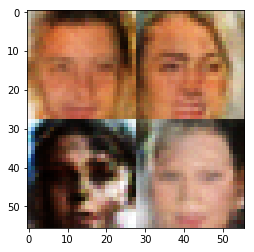

Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.4580
Epoch 1/1... Discriminator Loss: 0.8767... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 0.4370... Generator Loss: 1.5502
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.5309
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 0.4258... Generator Loss: 1.6943
Epoch 1/1... Discriminator Loss: 0.7771... Generator Loss: 1.3221
Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 0.4107
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.3765
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 4.6853


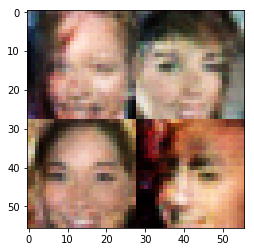

Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 0.3764... Generator Loss: 2.0192
Epoch 1/1... Discriminator Loss: 1.8491... Generator Loss: 0.2581
Epoch 1/1... Discriminator Loss: 0.8448... Generator Loss: 2.6521
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 1.6723... Generator Loss: 0.3206
Epoch 1/1... Discriminator Loss: 0.8143... Generator Loss: 0.9615
Epoch 1/1... Discriminator Loss: 0.7533... Generator Loss: 1.0085
Epoch 1/1... Discriminator Loss: 0.7187... Generator Loss: 1.4682
Epoch 1/1... Discriminator Loss: 0.7336... Generator Loss: 0.9939


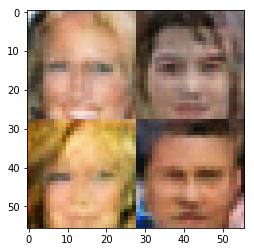

Epoch 1/1... Discriminator Loss: 0.7732... Generator Loss: 2.6948
Epoch 1/1... Discriminator Loss: 1.5104... Generator Loss: 0.3501
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.4937
Epoch 1/1... Discriminator Loss: 0.6048... Generator Loss: 1.4016
Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 1.2329
Epoch 1/1... Discriminator Loss: 0.7421... Generator Loss: 1.0106
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 4.3504
Epoch 1/1... Discriminator Loss: 0.7060... Generator Loss: 2.3008


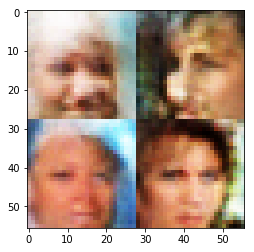

Epoch 1/1... Discriminator Loss: 0.7332... Generator Loss: 1.4441
Epoch 1/1... Discriminator Loss: 0.4378... Generator Loss: 1.7056
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.3619
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 0.8344... Generator Loss: 1.3369
Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 2.4886
Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 0.5296
Epoch 1/1... Discriminator Loss: 0.6554... Generator Loss: 1.1008
Epoch 1/1... Discriminator Loss: 0.6893... Generator Loss: 1.2134


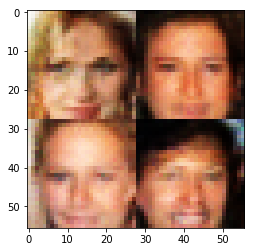

Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 0.5063... Generator Loss: 1.5855
Epoch 1/1... Discriminator Loss: 0.9983... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 0.5904... Generator Loss: 1.3276
Epoch 1/1... Discriminator Loss: 0.7769... Generator Loss: 1.9721
Epoch 1/1... Discriminator Loss: 0.6897... Generator Loss: 2.3361
Epoch 1/1... Discriminator Loss: 0.7718... Generator Loss: 1.0333
Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 0.8284... Generator Loss: 1.1129
Epoch 1/1... Discriminator Loss: 0.5386... Generator Loss: 1.6020


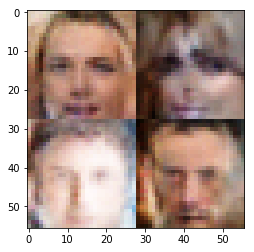

Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.4023
Epoch 1/1... Discriminator Loss: 0.6762... Generator Loss: 1.6226
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 2.9129
Epoch 1/1... Discriminator Loss: 1.7699... Generator Loss: 0.2703
Epoch 1/1... Discriminator Loss: 0.7733... Generator Loss: 0.9670
Epoch 1/1... Discriminator Loss: 0.7861... Generator Loss: 1.9246
Epoch 1/1... Discriminator Loss: 0.7082... Generator Loss: 1.7934
Epoch 1/1... Discriminator Loss: 1.7360... Generator Loss: 0.2889
Epoch 1/1... Discriminator Loss: 1.7902... Generator Loss: 0.3314


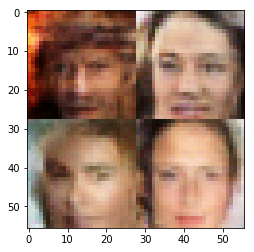

Epoch 1/1... Discriminator Loss: 0.7389... Generator Loss: 1.5867
Epoch 1/1... Discriminator Loss: 0.6472... Generator Loss: 1.8122
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.3972
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.3924
Epoch 1/1... Discriminator Loss: 1.6653... Generator Loss: 0.3676
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 0.5140
Epoch 1/1... Discriminator Loss: 0.7665... Generator Loss: 1.0803
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 0.4571... Generator Loss: 2.0732
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 0.6959


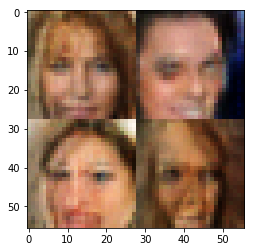

Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 1.1898
Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 0.3691
Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 0.8376... Generator Loss: 2.0039
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.5265
Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 2.5535
Epoch 1/1... Discriminator Loss: 0.5474... Generator Loss: 1.1787
Epoch 1/1... Discriminator Loss: 2.4642... Generator Loss: 0.1888
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 0.5785


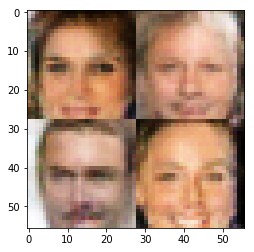

Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 0.8063... Generator Loss: 2.6074
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.5113
Epoch 1/1... Discriminator Loss: 0.7245... Generator Loss: 1.2043
Epoch 1/1... Discriminator Loss: 0.6253... Generator Loss: 2.4133
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.3831
Epoch 1/1... Discriminator Loss: 0.4281... Generator Loss: 2.5797
Epoch 1/1... Discriminator Loss: 0.8388... Generator Loss: 1.9944
Epoch 1/1... Discriminator Loss: 0.6857... Generator Loss: 1.3474
Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 0.9697


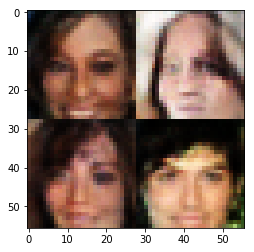

Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 0.6346... Generator Loss: 2.2871
Epoch 1/1... Discriminator Loss: 0.8425... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.0341... Generator Loss: 1.2445
Epoch 1/1... Discriminator Loss: 1.6855... Generator Loss: 0.3179
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 0.6509... Generator Loss: 1.8128
Epoch 1/1... Discriminator Loss: 0.9627... Generator Loss: 2.0967
Epoch 1/1... Discriminator Loss: 0.8587... Generator Loss: 3.5773


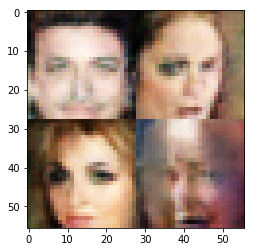

Epoch 1/1... Discriminator Loss: 0.5645... Generator Loss: 2.1513
Epoch 1/1... Discriminator Loss: 0.6712... Generator Loss: 1.3092
Epoch 1/1... Discriminator Loss: 0.6979... Generator Loss: 1.5524
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 0.6505... Generator Loss: 1.6000
Epoch 1/1... Discriminator Loss: 0.6909... Generator Loss: 1.1199


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.